# Assessent of mitosis-mediated phototoxicity temporal footprint

This notebook assumes that you already processed the videos using StarDist or any other segmentation method. It expects `.tif` video files with the instance mask of each identified cell (*i.e.*, the mask of each cell has a different value). Tracking of the segmented cells is not needed.

The data is assumed to be organised in a folders as follows. The Subcategories are the ones that the code uses to display the data. The labels will be identical to the folder name, so same conditions should always have the same folder name.

   ```
   general_path:
   
   -Raw-images (folder)
    |
    |--Biological-replica-date-1 (folder) [Subcaegory-00]
        |
        |--Cell density / UV Ligth / WL 475 light [Subcategory-01] 
           |
           |-- control-condition (folder) [Subcategory-02] 
           |    |  file1.tif
           |    |  file2.tif
           |    |  ...
           |
           |-- condition1 (folder) [Subcategory-02] 
           |    |  file1.tif
           |    |  file2.tif
           |    |  ...
           |
           |-- condition2 (folder) [Subcategory-02] 
           |    |  file1.tif
           |    |  file2.tif
           |    |  ...
        |
        |--Cell density / UV Ligth / WL 475 light [Subcategory-01]
        ...
        
    -Masks (folder)
    |
    |--Biological-replica-date-1 (folder) [Subcaegory-00]
        |
        |--Cell density / UV Ligth / WL 475 light [Subcategory-01] 
           |
           |-- control-condition (folder) [Subcategory-02] 
           |    |  file1.tif
           |    |  file2.tif
           |    |  ...
           |
           |-- condition1 (folder) [Subcategory-02] 
           |    |  file1.tif
           |    |  file2.tif
           |    |  ...
           |
           |-- condition2 (folder) [Subcategory-02] 
           |    |  file1.tif
           |    |  file2.tif
           |    |  ...
        |
        |--Cell density / UV Ligth / WL 475 light [Subcategory-01]
        ...
   ```

## 0. Import all the required dependencies

In [59]:
import os
import numpy as np
import pandas as pd
import photofitt
from photofitt.analysis import count_mitosis_all, quantify_peaks, compare_peaks, total_cell_number, add_inferred_nuclei, estimate_proportional_deviations
from photofitt import display
from photofitt.analysis import extract_gaussian_params
from photofitt.utils import power_conversion, numerical_dose
import seaborn as sns
import matplotlib.pyplot as plt
from photofitt.display import conditions_with_aggregates
from photofitt.analysis import cumulative_activity

### 0.1 Provide some input information

In [60]:
masks_path = "/home/ocb/HardDrive_4TB/EGM/PHX/DATA/MASKS/SYNCHRO/scaled_1.5709_results/stardist_prob03"
frame_rate = 4 # The time gap we will use to compute all the metrics
output_path =  "/Users/esti/Documents/PROYECTOS/PHX/DOCS/MANUSCRIPT/CODE/data/synchro/publication-data/"
os.makedirs(output_path, exist_ok=True)
os.makedirs(os.path.join(output_path, "plots"), exist_ok=True)

## 1. Count the number of mitoses

In [4]:
data = count_mitosis_all(masks_path, frame_rate = frame_rate)
# save the information
data.to_csv(os.path.join(output_path, "mitosis_counting.csv"))

['2022-08-03-night', '2022-08-09', '2022-08-09-night', '2022-08-10', '2022-08-12', '2022-09-07-day', '2022-09-07-night', '2022-09-08-day', '2022-09-08-night', '2022-09-09-day', '20220928_night', '20220929_night', '20221012_night', '20221013_night', '20221014', '20230504_630_day', '20230505_475_day']
Frame rate of this folder is 4
['.DS_Store', '._.DS_Store', 'WL UV - high density']
Frame rate of this folder is 4
['.DS_Store', '._.DS_Store', '100ms', '200ms', '25ms', '400ms', '50ms', '800ms', 'Control-sync', 'Synchro']
Frame rate of this folder is 4
['._CHO_live_night_live-01-Scene-31-P1-A04.tif', '._CHO_live_night_live-01-Scene-31-P1-A04_Nuclei_number.csv', '._CHO_live_night_live-01-Scene-31-P1-A04_Object_detected_vs_frame_number.png', '._CHO_live_night_live-01-Scene-32-P2-A04.tif', '._CHO_live_night_live-01-Scene-32-P2-A04_Nuclei_number.csv', '._CHO_live_night_live-01-Scene-32-P2-A04_Object_detected_vs_frame_number.png', '._CHO_live_night_live-01-Scene-33-P3-A04.tif', '._CHO_live_nigh

### 1.0 Add the total number of cells information, normalise the cell counting and convert light exposure times into light dose units

In [5]:
import sys
import os
import pandas as pd
sys.path.append("/home/ocb/HardDrive_4TB/EGM/PHX/PhotoFITT/photofitt/analysis/")
from mitosis_counting import total_cell_number,add_inferred_nuclei

cell_number = total_cell_number("/media/ocb/OCB-Data2/PhotoFiTT/PIX2PIX/SINGLE_FRAMES/STARDIST/CHO-SYNCHRO/", type="image")
cell_number.to_csv(os.path.join(output_path, "cell_counting_pix2pix.csv"))

# If you stored the data in a previous session, you can load it again as follows:
data = pd.read_csv(os.path.join(output_path, "mitosis_counting.csv"))
updated_data = add_inferred_nuclei(data, cell_number)
# -----
updated_data["Cell percentage"] = updated_data["Number of cells"] / updated_data['cell_counts_stardist']
data_filtered = updated_data.loc[lambda updated_data: updated_data["Cell percentage"] <= 1] # Remove anny potential frame that was not well segmented
data_filtered.to_csv(os.path.join(output_path, "normalised_mitosis_counting_pix2pix.csv"))

# Estimate the ligth dose
light_power = 6.255662 # fixed power value according to our microscope
data = photofitt.utils.numerical_dose(data_filtered, column_name="Subcategory-02", power=light_power)
data = power_conversion(data, dose_column="Light dose", condition_col="Subcategory-02", condition_name="Synchro")
data.to_csv(os.path.join(output_path, "normalised_mitosis_counting_pix2pix.csv"))

del updated_data, data_filtered, cell_number

Processing folder 2022-08-03
Processing folder 2022-08-03-night
Processing folder 2022-08-09
Processing folder 2022-08-12
Processing folder 20220928_night
Processing folder 20220929_night
Processing folder 20221012_night
Processing folder 20221013_night
Processing folder 20221014
Processing folder 2022-08-10
Processing folder 2022-09-07-day
Processing folder 20220906-night
Processing folder 2022-09-08-day
Processing folder 2022-09-08-night
Processing folder 2022-09-09-day
Processing folder 20220928_day
Processing folder 2022-08-09-night
Processing folder 2022-09-07-night
Processing folder 20230503_475_night
Processing folder 20230504_630_day
Processing folder 20230504_630_night
Processing folder 20230505_475_day
2022-08-03
2022-08-03-night
2022-08-09
2022-08-09-night
2022-08-10
2022-08-12
2022-09-07-day
2022-09-07-night
2022-09-08-day
2022-09-08-night
2022-09-09-day
20220906-night
20220928_day
20220928_night
20220929_night
20221012_night
20221013_night
20221014
20230503_475_night
20230

### 1.2 Display the results per condition

The next code will create a bunch of plots considering all the conditions and experimental replicas. By default, it will export the plots as .png, but you can also specify the `graph_format='png'` in the function.

We will show afterward how to plot this data for one single condition.

In [93]:
def diam_estimation(size):
    d = 2*np.sqrt(size/np.pi)
    return d
print(diam_estimation(600)*0.8633995)
print(diam_estimation(200)*0.8633995)


from photofitt.display import conditions, one_condition, distributions, dual_boxplots, cellsize_distributions
from photofitt.utils import power_conversion, numerical_dose
import numpy as np
import os
import pandas as pd
from ast import literal_eval


def display_data_from_masks_1(data, output_path, roundness=0, graph_format='png',
                            hue_order=None,
                            reduced_hue=None,
                            palette="coolwarm",
                            time_limit=120,
                            time_points=None,
                            time_colours= ["#BC77F8", "#99E3D7", "#FC9F30", "#FF4126"],
                            xlim=1200,
                            density_ylim=0.00030,
                            common_norm=False,
                            orient="h",
                            pixel_size=0.8633995):
    """
    PLOT THE RESULTS FOR EACH CONDITION SEPARATELY:
    Subcategory-02 filters out the different experimental condition such as control, synch, uv10sec or uv 30sec
    (last level of the folder organisation)
    :param graph_format:
    :param data:
    :param output_path:
    :param frame_rate:
    :param roundness:
    :return:
    """

    density = np.unique(data['Subcategory-01'])

    for d in density:
        print(d)
        data_d = data[data["Subcategory-01"] == d].reset_index(drop=True)

        # TEMPORAL DISTRIBUTION OF SIZE
        # --------------------------------------------------------------
        ## Obtain cell size
        data_display = None
        if pd.api.types.is_string_dtype(data_d["cell_size"].dtype):
            data_d["cell_size"] = data_d["cell_size"].apply(literal_eval)

        if pd.api.types.is_string_dtype(data_d["roundness_axis"].dtype):
            data_d["roundness_axis"] = data_d["roundness_axis"].apply(literal_eval)

        for i in range(len(data_d)):
            cell = data_d.iloc[i]
            if cell.cell_size != []:
                CS = cell["cell_size"]
                RA = cell["roundness_axis"]
                t = cell["frame"]
                S0 = cell["Subcategory-01"]  # Density
                S1 = cell["Subcategory-02"]  # Condition
                aux_data = [[t, CS[f], RA[f], S0, S1] for f in range(len(RA)) if RA[f] > roundness]
                col_names = ["frame", "cell_size", "roundness_axis", "Subcategory-00", "Subcategory-01"]
                aux = pd.DataFrame(aux_data, columns=col_names)
                if data_display is None:
                    data_display = aux
                else:
                    data_display = pd.concat([data_display, aux]).reset_index(drop=True)

        # Estimate the ligth dose
        light_power = 6.255662 # fixed power value according to our microscope
        data_display = numerical_dose(data_display, column_name="Subcategory-01", power=light_power)
        data_display = power_conversion(data_display, dose_column="Light dose", condition_col="Subcategory-01", condition_name="Synchro")
        data_display["diameter [um]"] = 2*(np.sqrt(data_display["cell_size"]/np.pi))*pixel_size
        variable = "diameter [um]"
        data_display.to_csv(os.path.join(output_path, f"data_display_cellsize_{d}.csv"))
        
        # Classify cells according to their size
        data_display["cell-class"]="mother"
        data_display.loc[data_display["cell_size"]<350, "cell-class"]="daughter"
        aux = data_display.loc[data_display["frame"]<180]
        aux = aux.reset_index(drop=True)
        

        # if orient=="v":
        #     x_var = 'Light dose cat'
        #     y_var = "frame"
        #     ylabel = "Time [min]"
        #     xlabel = "Light dose [J/cm2]"
        #     figsize = (7, 5)
        # else:
        #     y_var = 'Light dose cat'
        #     x_var = "frame"
        #     ylabel = "Light dose [J/cm2]"
        #     xlabel = "Time [min]"
        #     figsize = (5, 7)


        # dual_boxplots(aux, output_path, f"{d}_cellclass_time.{graph_format}",
        #               x_var=x_var, y_var=y_var, hue_var="cell-class", x_order=hue_order,
        #               hue_order=["mother", "daughter"],
        #               ylabel=ylabel, xlabel=xlabel, palette=['#C9C9C9', '#FFA500'], figsize=figsize, graph_format=graph_format)

        # if reduced_hue is not None:
        #     dual_boxplots(aux, output_path, f"{d}_cellclass_time_reduced.{graph_format}",
        #                   x_var=x_var, y_var=y_var, hue_var="cell-class", x_order=reduced_hue,
        #                   hue_order=["mother", "daughter"],
        #                   ylabel=ylabel, xlabel=xlabel, palette=['#C9C9C9', '#FFA500'], figsize=figsize, graph_format=graph_format)

        if time_points is not None:
            aux = None
            for t in time_points:
                new_data = data_display.loc[lambda data_display: data_display["frame"]==t]
                if aux is None:
                    aux = new_data
                else:
                    aux = pd.concat([aux, new_data]).reset_index(drop=True)
            data_display = aux
            del aux

        cellsize_distributions(data_display, output_path, f"{d}_cellsize_reduced.{graph_format}", reduced_hue,
                               variable=variable,
                               xlim=xlim,
                               hue_var="frame",
                               common_norm=common_norm,
                               time_points=time_points,
                               time_limit=time_limit,
                               x_label="Cell diameter [um]",
                               palette=palette,
                               density_ylim=density_ylim,
                               time_colours=time_colours,
                               figsize=(25, 5),
                               graph_format=graph_format)


23.863958072518106
13.777862617098272


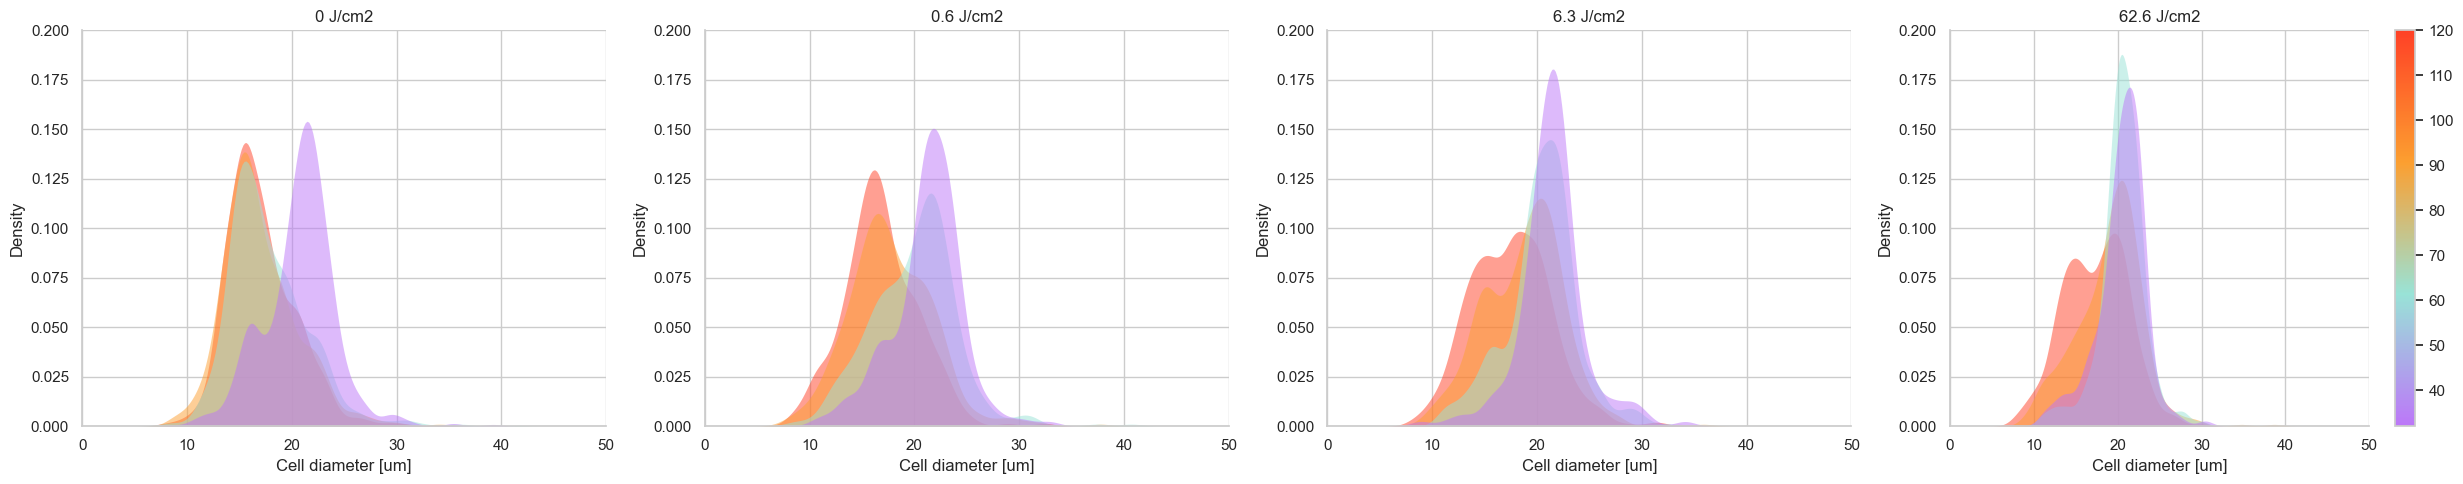

In [92]:
data_display = pd.read_csv(os.path.join(output_path, "plots", f"data_display_cellsize_WL UV - high density.csv"))

if time_points is not None:
    aux = None
    for t in time_points:
        new_data = data_display.loc[lambda data_display: data_display["frame"]==t]
        if aux is None:
            aux = new_data
        else:
            aux = pd.concat([aux, new_data]).reset_index(drop=True)
    data_display = aux
    del aux


graph_format='pdf',
variable = "diameter [um]"

cellsize_distributions(data_display, output_path, "WL UV - high density_cellsize_reduced.pdf", reduced_hue,
                       variable=variable,
                       xlim=50,
                       hue_var="frame",
                       common_norm=False,
                       time_points=[32, 60, 92, 120],
                       time_limit=120,
                       x_label="Cell diameter [um]",
                       palette="coolwarm",
                       density_ylim=0.20,
                       time_colours=colours,
                       figsize=(25, 5),
                       graph_format="pdf")


In [94]:
output_path

'/Users/esti/Documents/PROYECTOS/PHX/DOCS/MANUSCRIPT/CODE/data/synchro/publication-data/'

WL 475 - high density
WL 568 - high density
WL 630 - high density
WL UV - high density


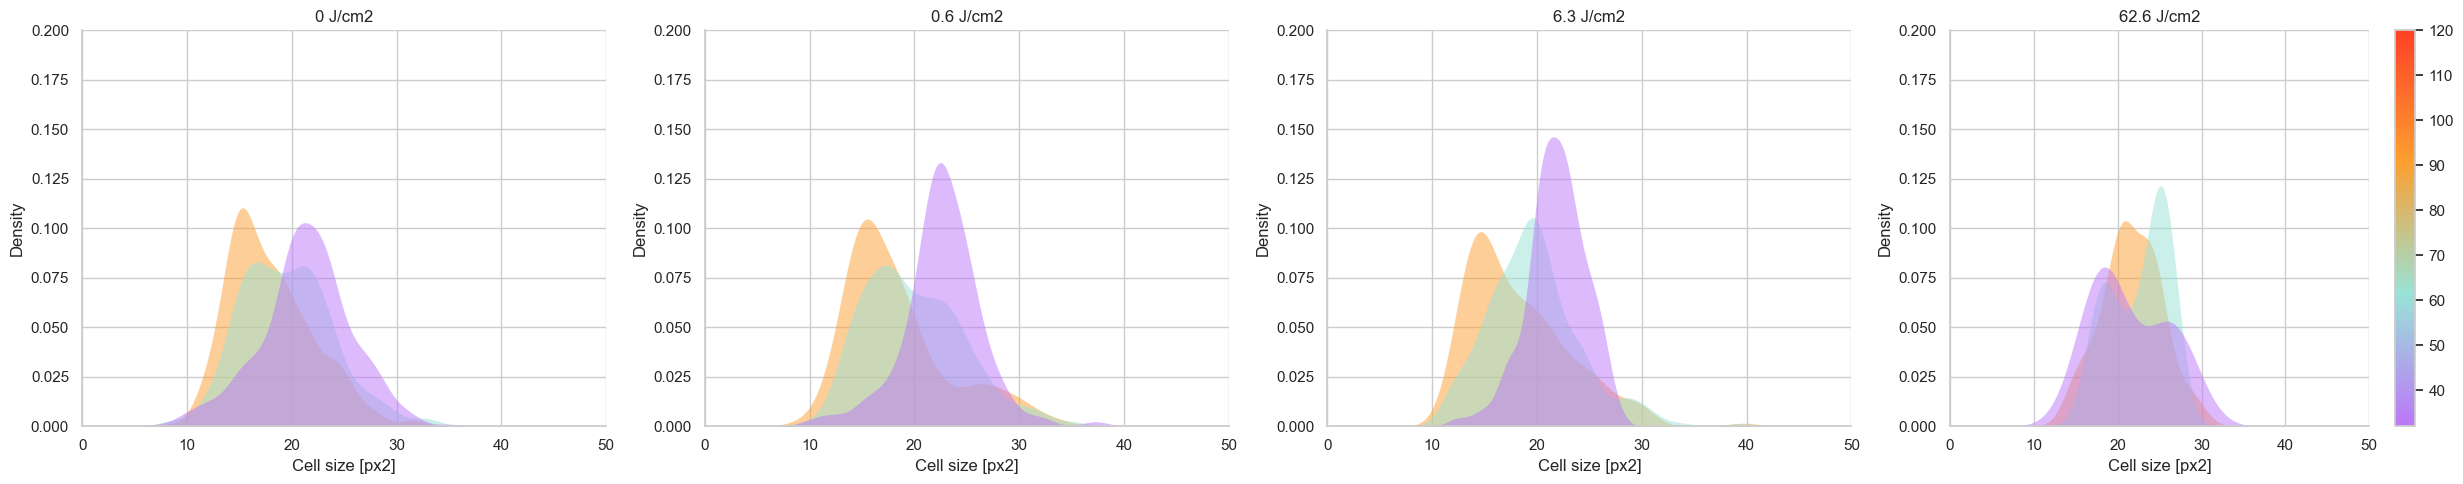

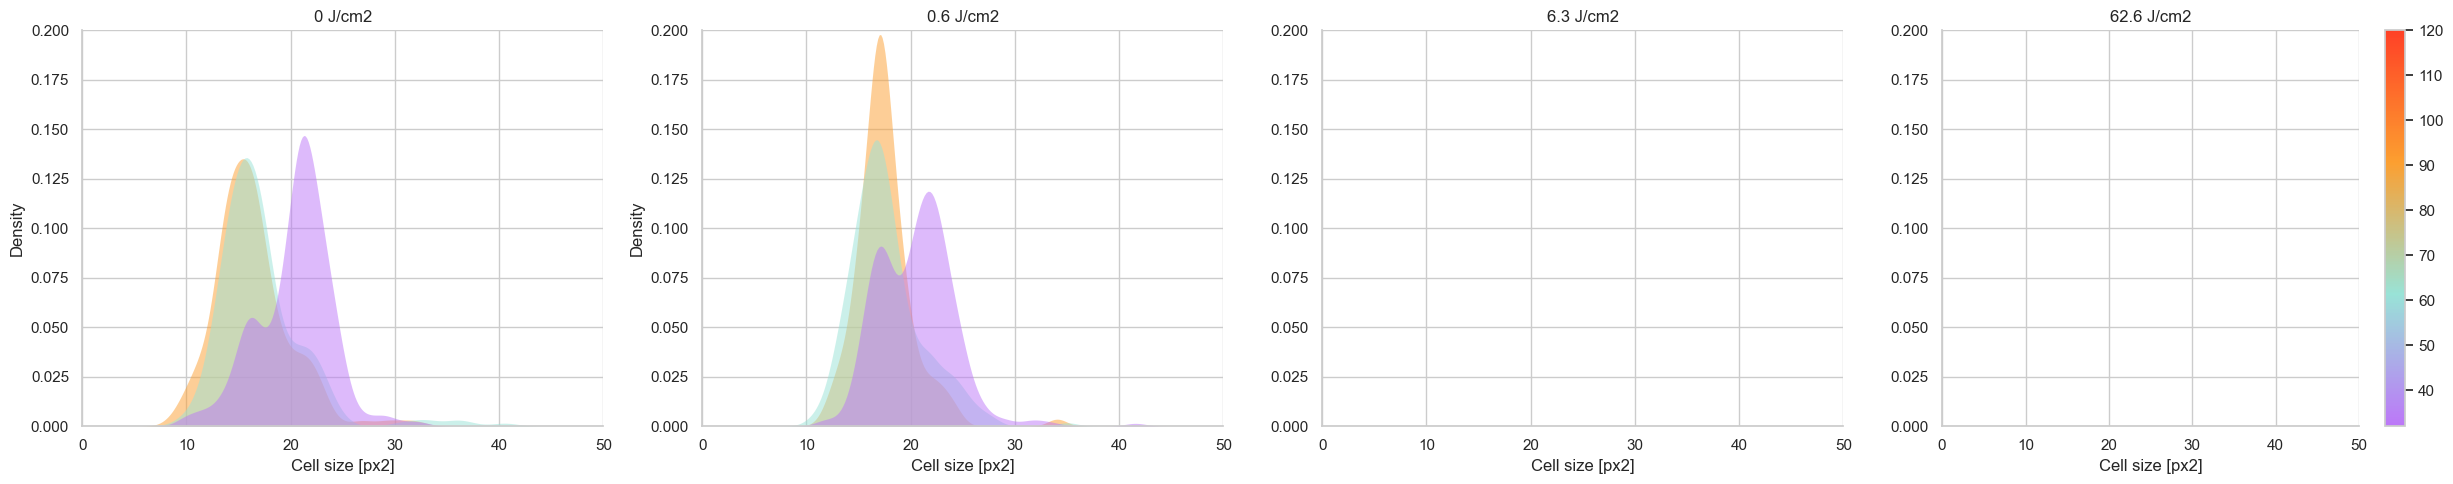

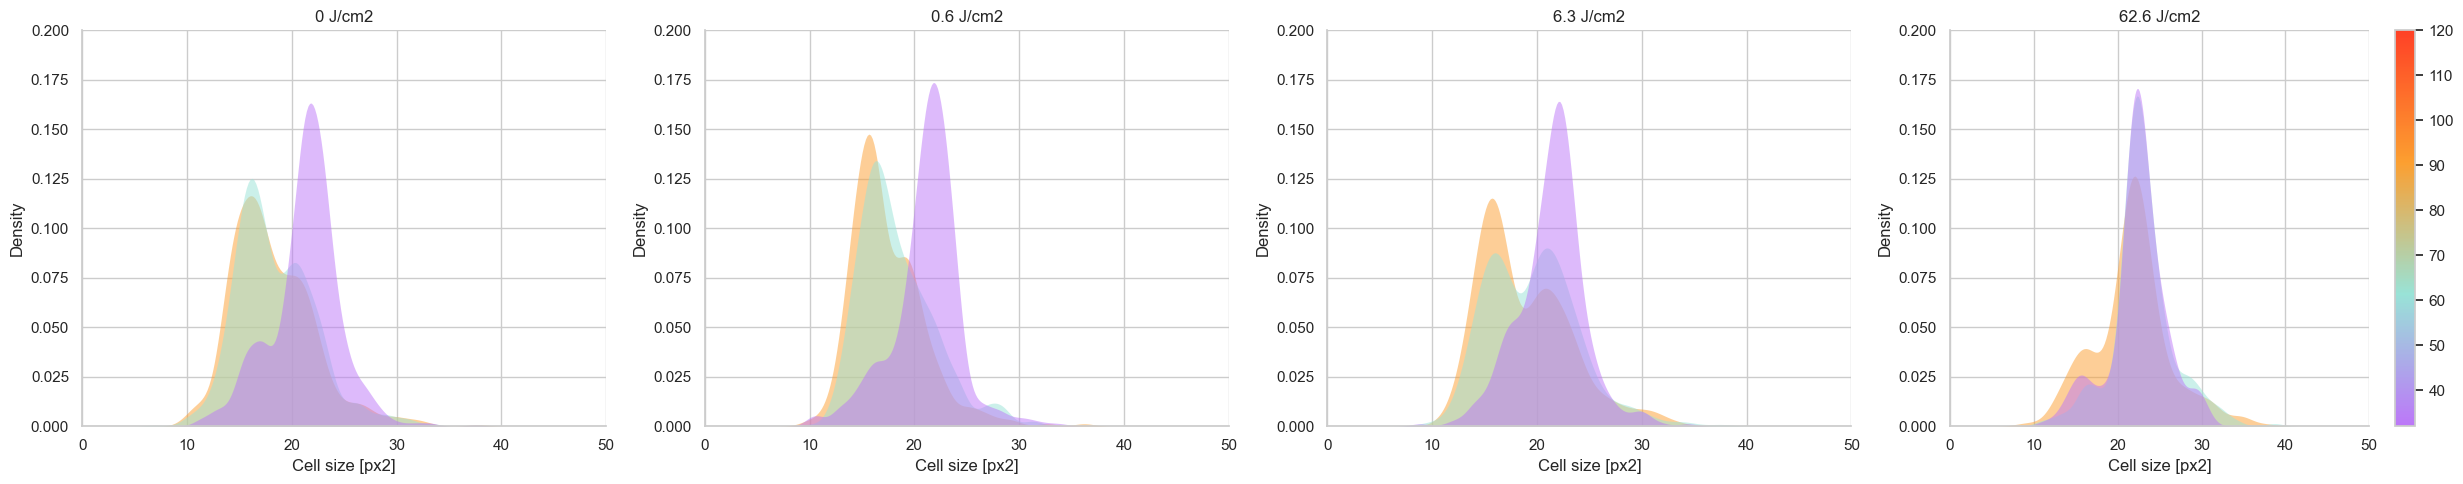

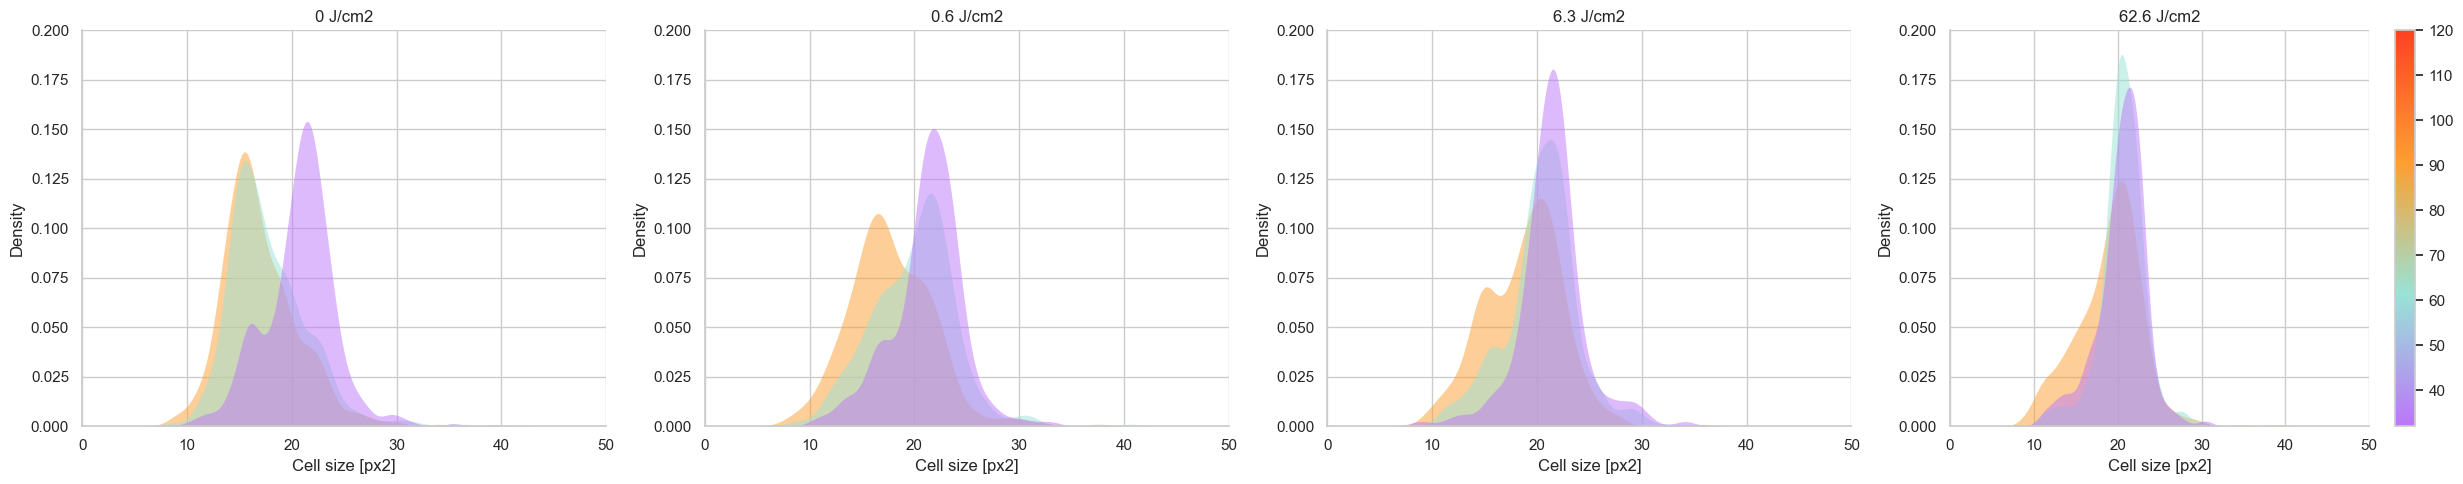

In [85]:
# If you stored the data in a previous session, you can load it again as follows:
data = pd.read_csv(os.path.join(output_path, "normalised_mitosis_counting_pix2pix.csv"))

# Control the order of the legend and the format to export the plots.
# If the order is unknown, let it as huer_order=None
hue_order = ['non-synchro-0 J/cm2', '0 J/cm2', '0.6 J/cm2', '6.3 J/cm2', '62.6 J/cm2']

#hue_order = ['Control-sync', 'Synchro', '25ms', '50ms', '100ms', '200ms', '400ms', '800ms',
#             '01sec', '05sec', '10sec', '15sec', '20sec', '25sec'] 
condition = "Light dose cat"
graph_format = ['pdf']
y_var = "Cell percentage"
time_points = [32, 60, 92, 120]
reduced_hue = ['0 J/cm2', '0.6 J/cm2', '6.3 J/cm2', '62.6 J/cm2']
colours = ["#BC77F8", "#99E3D7", "#FC9F30", "#FF4126"]
#colours = ["#bcc77f8", "#99e3d7", "#fc9f30", "#ff4126"]
# Plot the data

for g in graph_format:
    display_data_from_masks_1(data, os.path.join(output_path, "plots"),
                                    roundness=0.,
                                    graph_format=g, hue_order=hue_order, palette="cool",
                                    reduced_hue=reduced_hue, common_norm=False,
                                    time_limit=120, time_points=time_points, time_colours=colours, orient="h",
                                    density_ylim=0.20, xlim=50)


#### 1.2.1 Example of how to display the results per replica and condition

We plot the control and synchronised conditions per replica for one group (illuminated with a Wavelength of 475) to see the experimental reliability

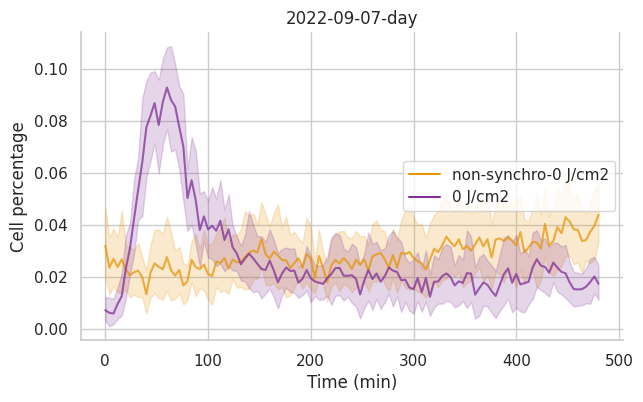

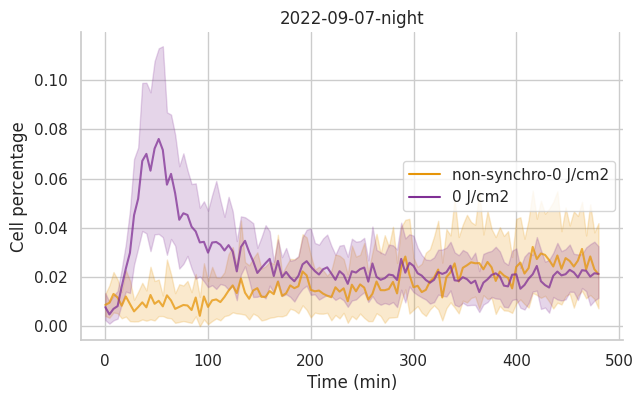

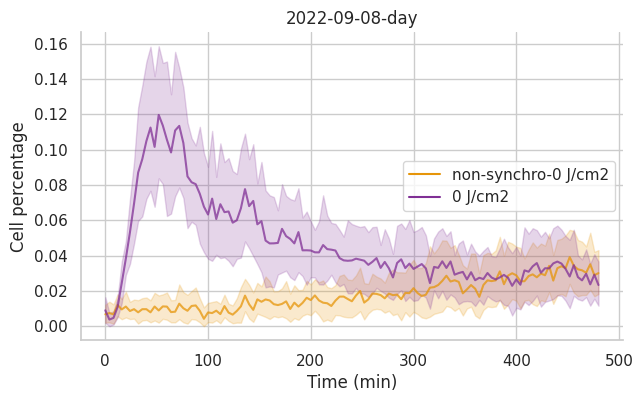

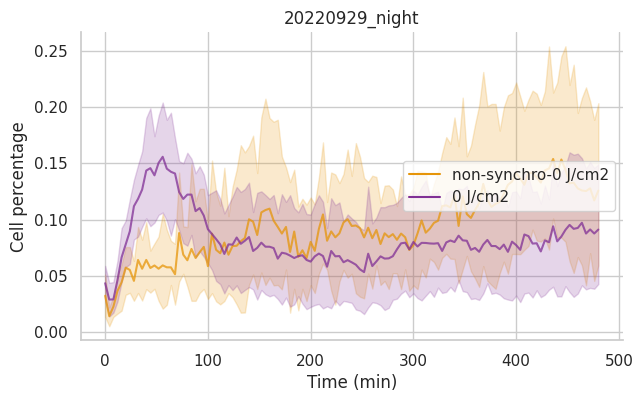

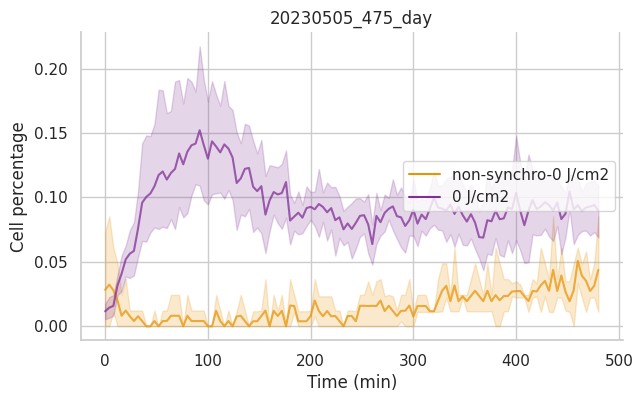

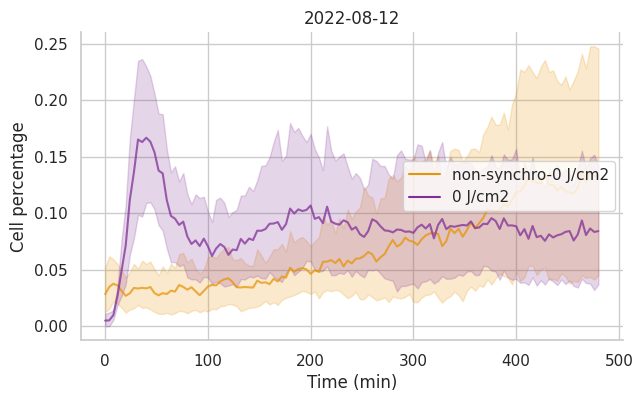

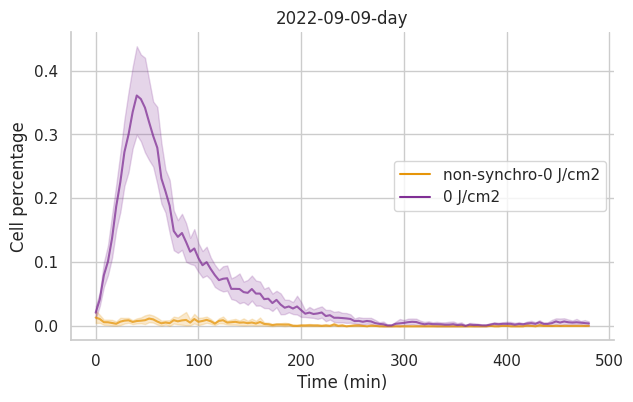

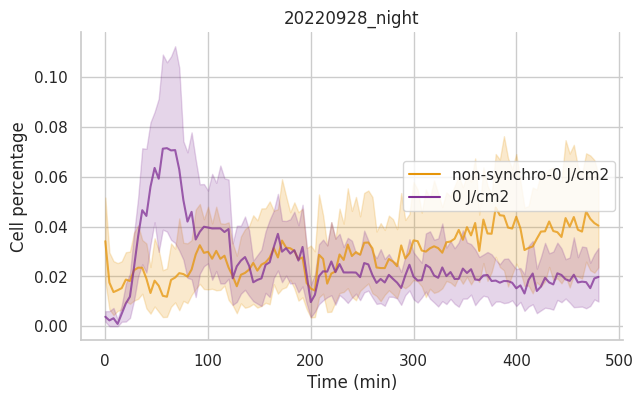

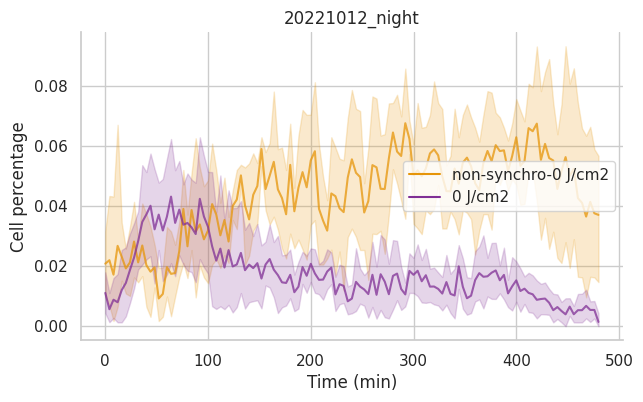

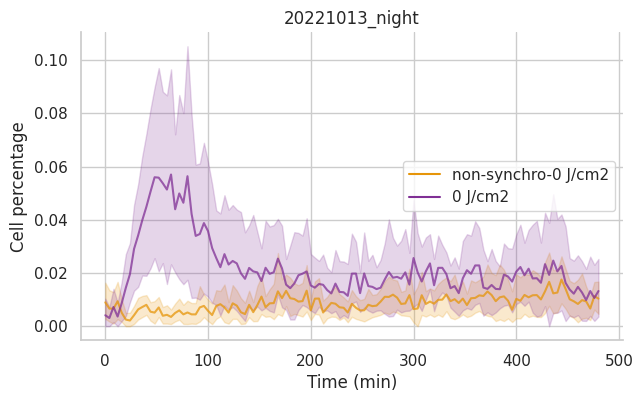

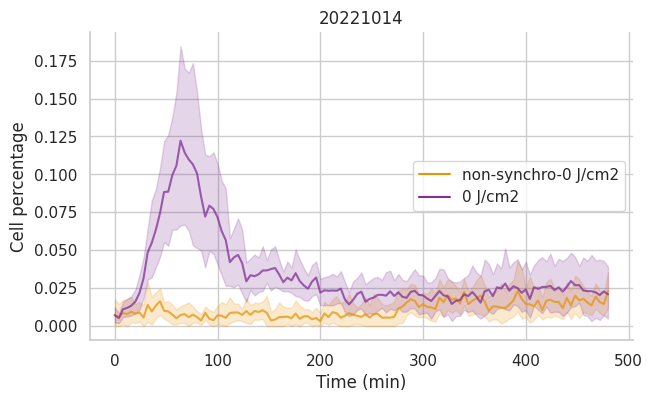

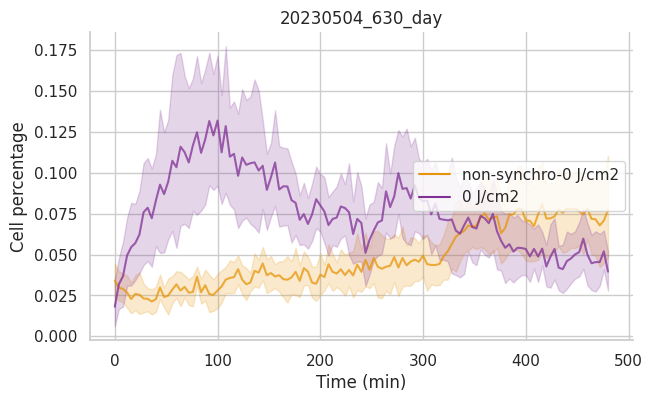

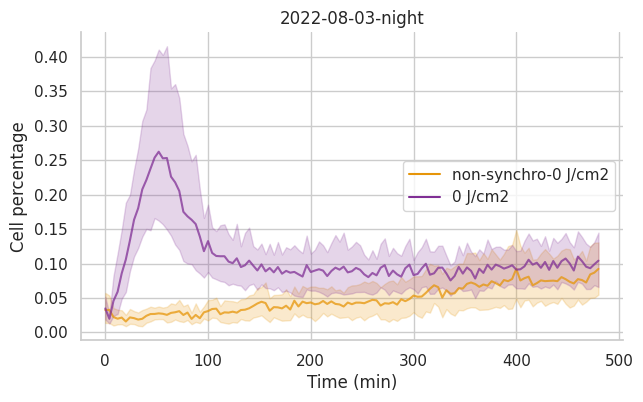

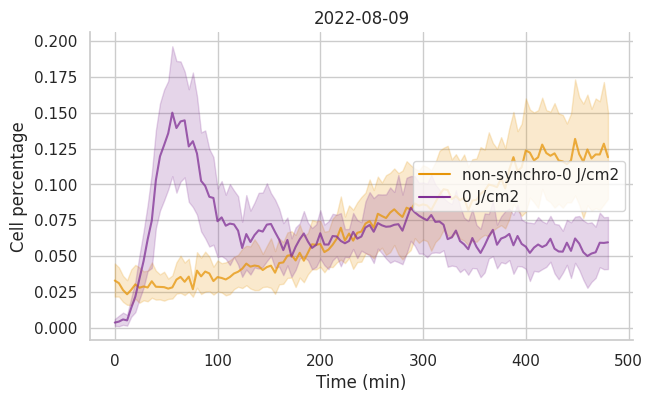

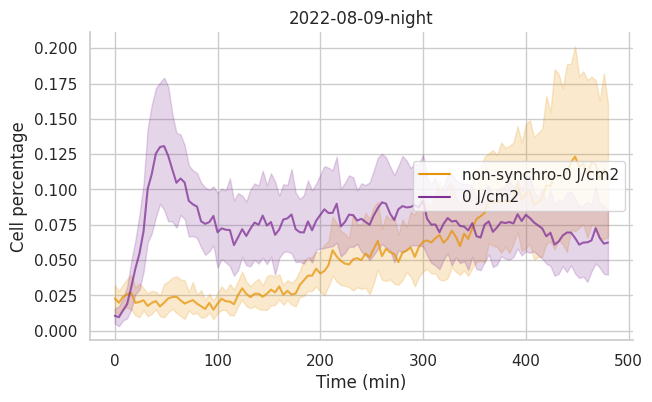

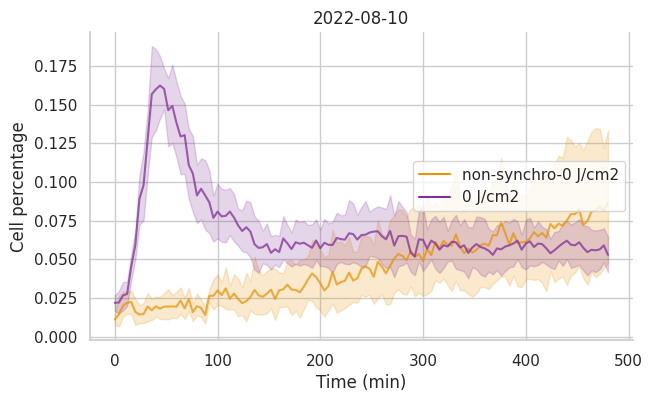

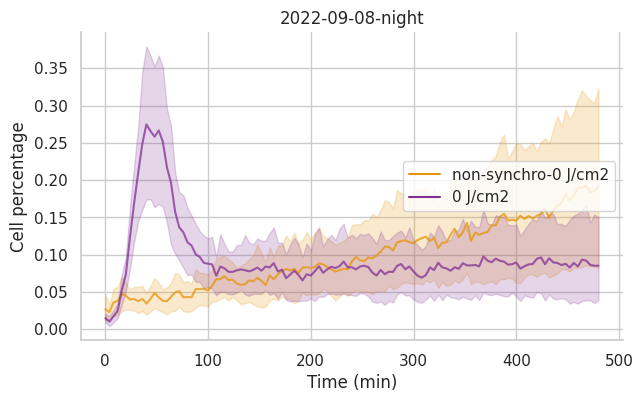

In [191]:
import seaborn as sns
data = pd.read_csv(os.path.join(output_path, "normalised_mitosis_counting_pix2pix.csv"))
wls = np.unique(data["Subcategory-01"])

smoothing = ['Raw']
## Name of the variable to display in the plot.
plot_y_var = "Cell percentage" #  "Percentage" # "Norm. Number of cells"
fig_format = ["png"] #, "pdf"]

hue_order_synchro = ['non-synchro-0 J/cm2', '0 J/cm2'] #, '0.2 J/cm2',
             # '0.3 J/cm2', '0.6 J/cm2', '1.3 J/cm2', '2.5 J/cm2',
             # '5.0 J/cm2', '6.3 J/cm2', '31.3 J/cm2', 
             # '62.6 J/cm2', '93.8 J/cm2', '125.1 J/cm2', '156.4 J/cm2', '187.7 J/cm2']
for w in wls:
    data_wl = data.loc[lambda data: data["Subcategory-01"]==w]
    groups = np.unique(data_wl["Subcategory-00"])
    for g in groups:
        ploting_data_g = data_wl[data_wl["Subcategory-00"]==g].reset_index(drop=True)  
        for s in smoothing:
            # sns.set_style()
            ploting_data = ploting_data_g[ploting_data_g["processing"]==s].reset_index(drop=True)    
            title = f"{g}"
            condition = "Light dose cat" # "Subcategory-02"
            #hue_order = ['Control-sync', 'Synchro', '25ms', '50ms', '100ms', '200ms', '400ms', '800ms',
                         #'01sec', '05sec', '10sec', '15sec', '20sec', '25sec']
            for f in fig_format:
                name = "Synchro_{0}_{1}_{2}_{3}.{4}".format(w, g, plot_y_var, s, f)
                display.conditions(ploting_data, plot_y_var, title, condition, os.path.join(output_path, "plots"), name,
                                hue_order=hue_order_synchro, palette=sns.color_palette("CMRmap_r", 2))

#### 1.2.2 Plot all the experimental data for each single wavelength, including all the conditions. Together and separated.

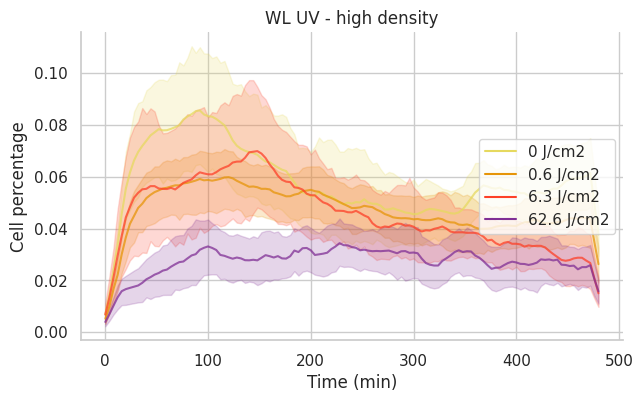

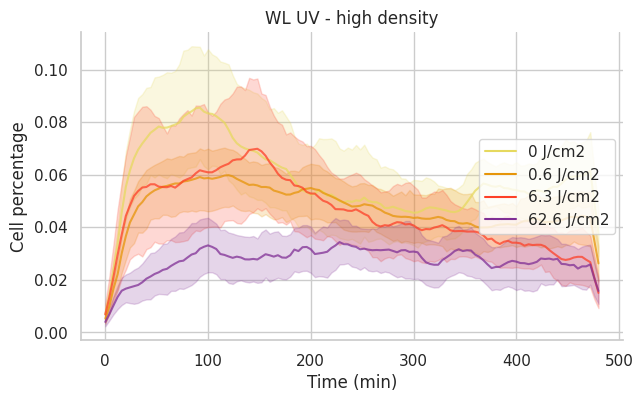

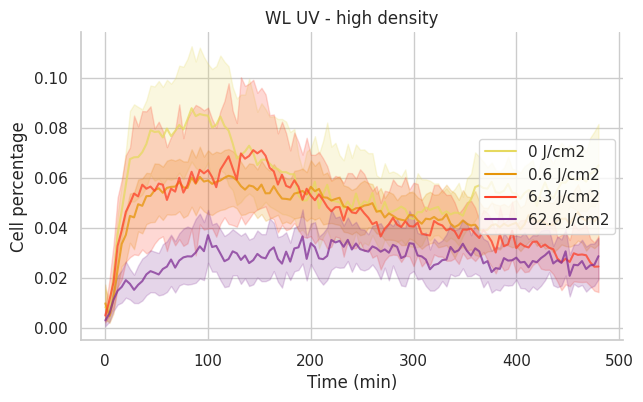

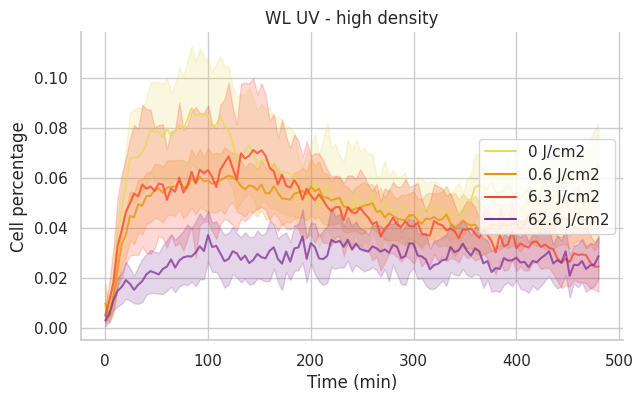

In [33]:
## Rename the columns to get the proper naming of the axis
#output_path = os.path.join(output_path, "plots")
#os.makedirs(output_path, exist_ok=True)
hue_order = ['non-synchro-0 J/cm2', '0 J/cm2', '0.2 J/cm2',
             '0.3 J/cm2', '0.6 J/cm2', '1.3 J/cm2', '2.5 J/cm2',
             '5.0 J/cm2', '6.3 J/cm2', '31.3 J/cm2', 
             '62.6 J/cm2', '93.8 J/cm2', '125.1 J/cm2', '156.4 J/cm2', '187.7 J/cm2']
hue_order = ['0 J/cm2', '0.6 J/cm2', '6.3 J/cm2','62.6 J/cm2']
## There is raw and smooth data. We show the smooth data (with a moving average of kernel 5) for the plots.
groups = np.unique(data["Subcategory-01"])
smoothing = np.unique(data["processing"])
## Name of the variable to display in the plot.
plot_y_var = "Cell percentage" #  "Percentage" # "Norm. Number of cells"
fig_format = ["png", "pdf"]
for g in groups:
    ploting_data_g = data[data["Subcategory-01"]==g].reset_index(drop=True)  
    for s in smoothing:
        # sns.set_style()
        ploting_data = ploting_data_g[ploting_data_g["processing"]==s].reset_index(drop=True)    
        title = f"{g}"
        condition = "Light dose cat" # "Subcategory-02"
        #hue_order = ['Control-sync', 'Synchro', '25ms', '50ms', '100ms', '200ms', '400ms', '800ms',
                     #'01sec', '05sec', '10sec', '15sec', '20sec', '25sec']
        for f in fig_format:
            name = "reduced_{0}_{1}_{2}.{3}".format(g, plot_y_var, s, f)
            display.conditions(ploting_data, plot_y_var, title, condition, os.path.join(output_path, "plots"), name,
                            hue_order=hue_order, palette=sns.color_palette("CMRmap_r", 5)) #17


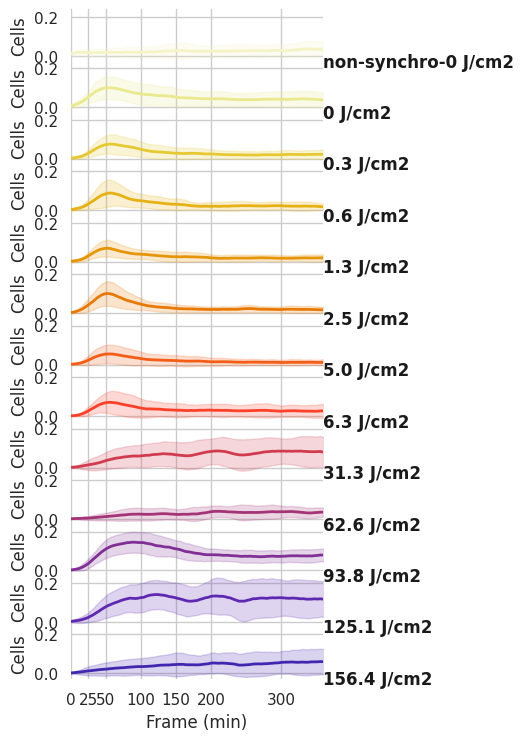

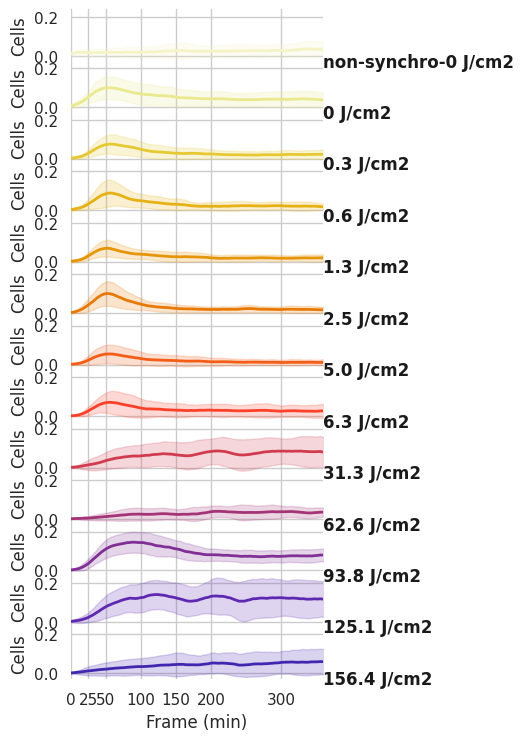

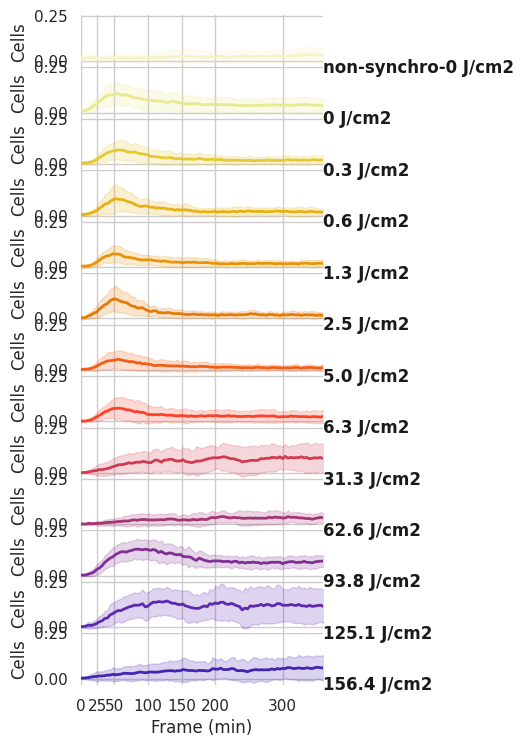

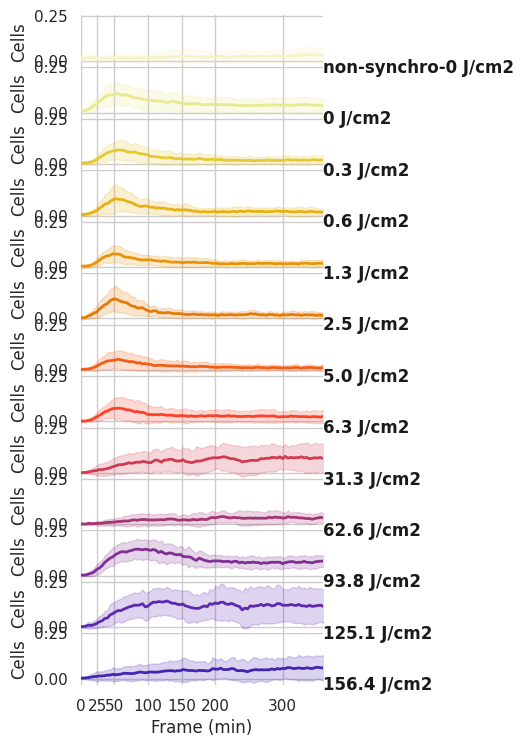

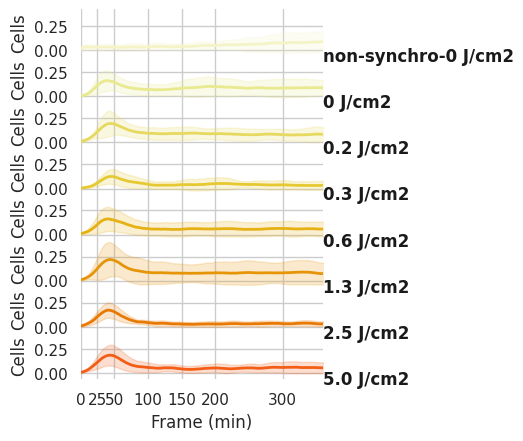

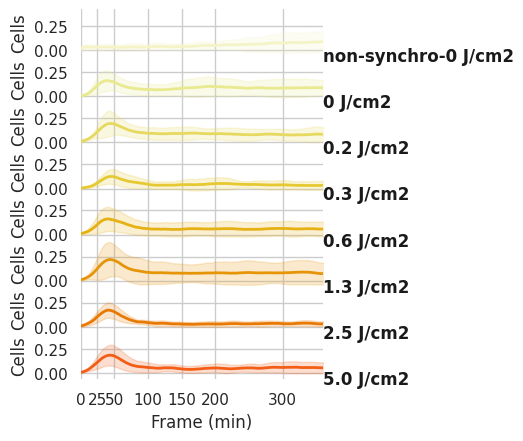

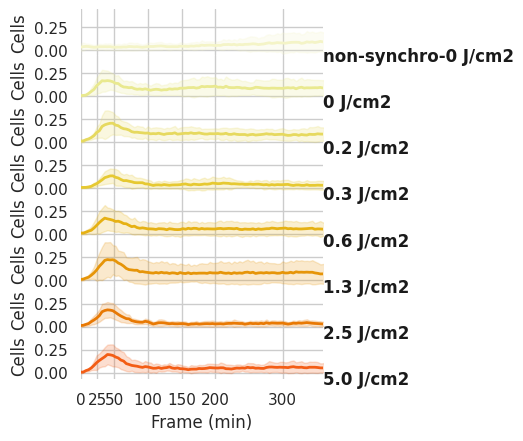

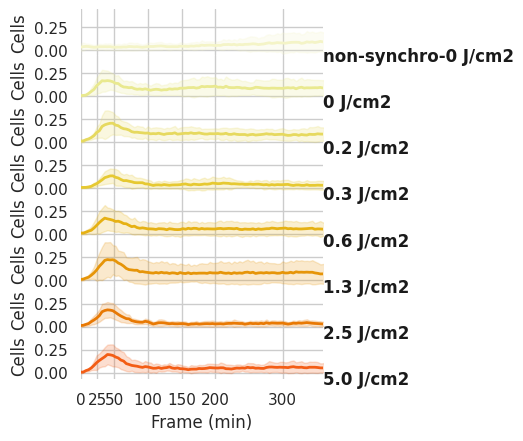

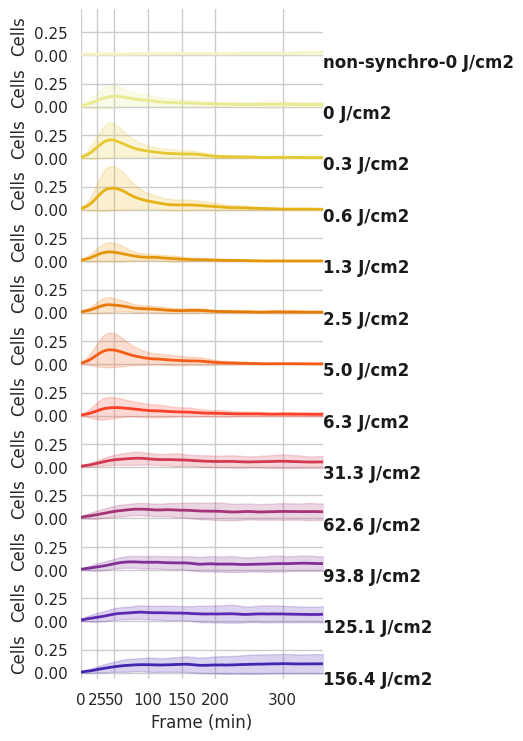

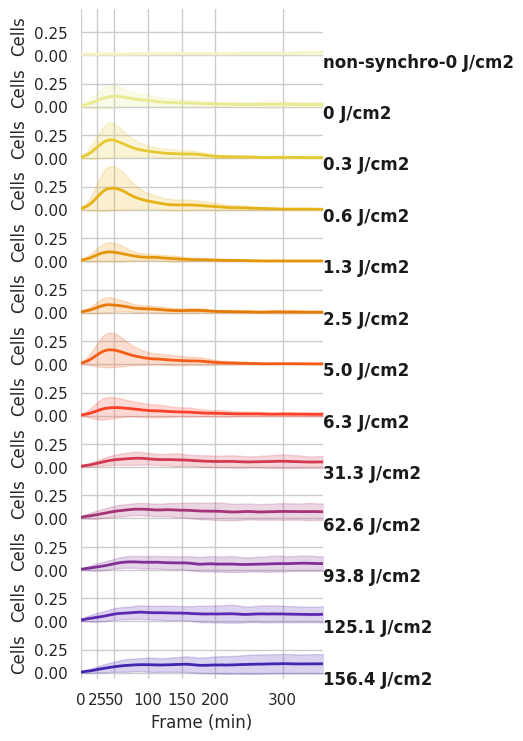

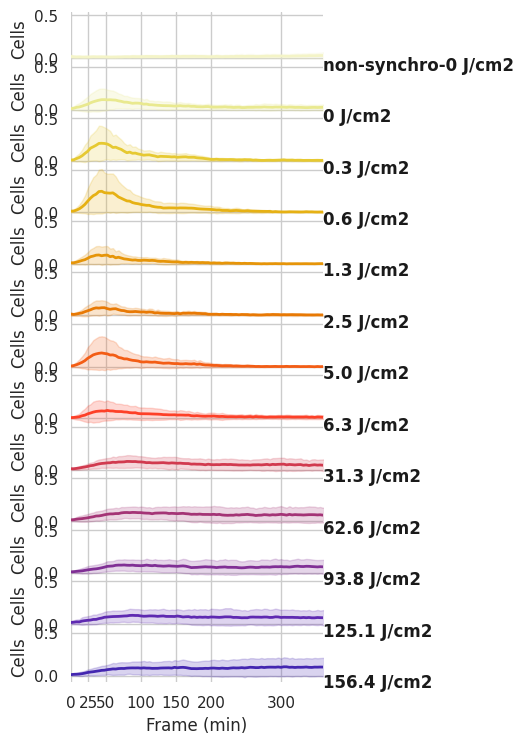

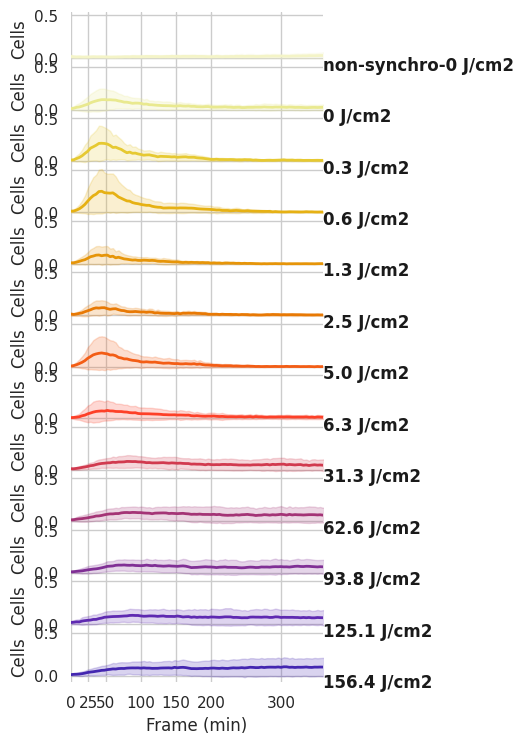

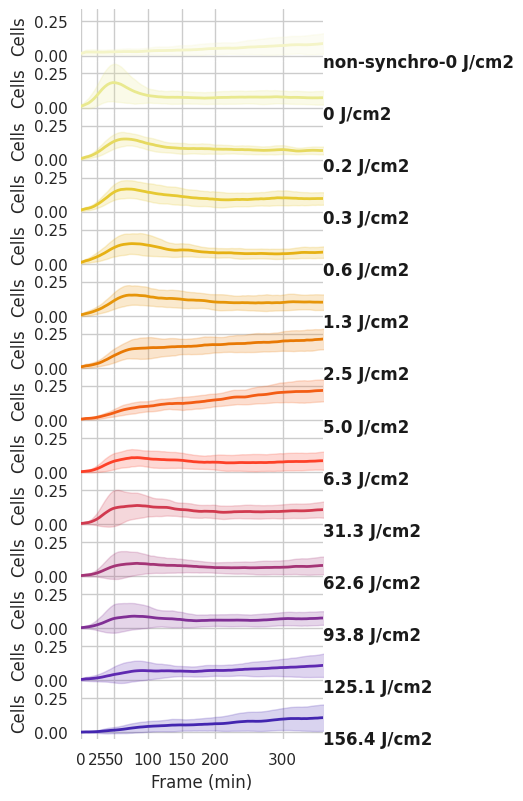

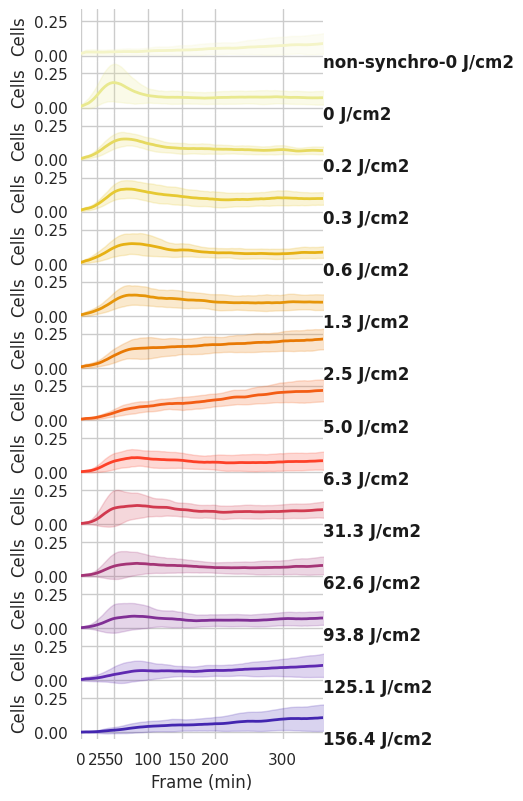

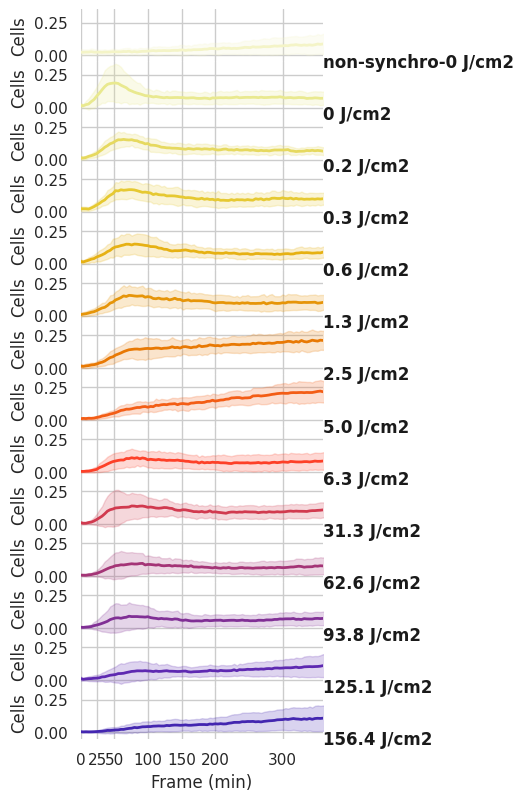

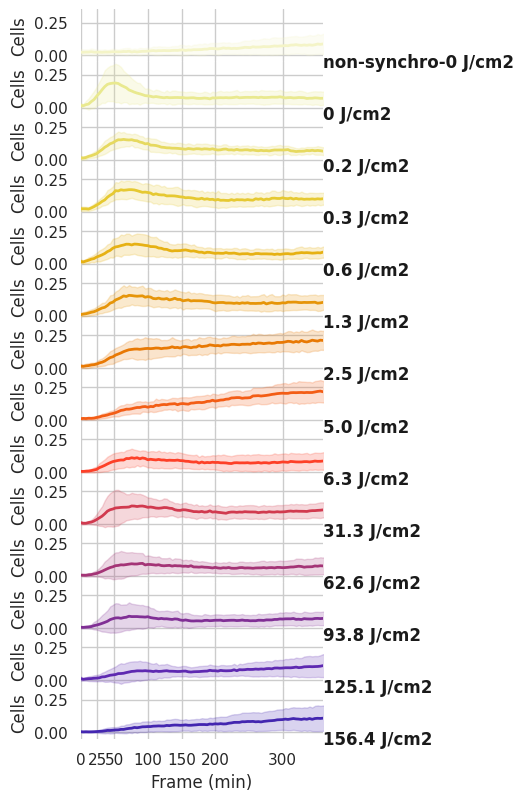

In [6]:
## Order the data for the plot
data = pd.read_csv(os.path.join(output_path, "normalised_mitosis_counting_pix2pix.csv"))
smoothing = np.unique(data["processing"])

hue_order = ['non-synchro-0 J/cm2', '0 J/cm2', '0.2 J/cm2',
             '0.3 J/cm2', '0.6 J/cm2', '1.3 J/cm2', '2.5 J/cm2',
             '5.0 J/cm2', '6.3 J/cm2', '31.3 J/cm2', 
             '62.6 J/cm2', '93.8 J/cm2', '125.1 J/cm2', '156.4 J/cm2']
plot_y_var = "Cell percentage" 
wl = np.unique(data["Subcategory-01"])
fig_format = ["png", "pdf"]
for w in wl:
    data_w = data.loc[lambda data: data["Subcategory-01"]==w]
    for s in smoothing:
        ploting_data = data_w[data_w["processing"]==s].reset_index(drop=True)   
        for f in fig_format:
            name = "{0}_{1}_{2}.{3}".format(w, plot_y_var, s, f) # name we want to give to the plot
            new_name="cells_vertical_subplots_{}".format(name)
        
            display.vertical_distributions(ploting_data, plot_y_var, os.path.join(output_path, "plots"), 
                                           new_name, 
                                           ylabel="Cells",
                                           raw="Light dose cat",
                                           hue="Light dose cat", 
                                           hue_order=hue_order, 
                                           palette=sns.color_palette("CMRmap_r", 17))

#### 1.2.3 Plot the percentage of cells in pre-mitotic rounding for a certain timepoint

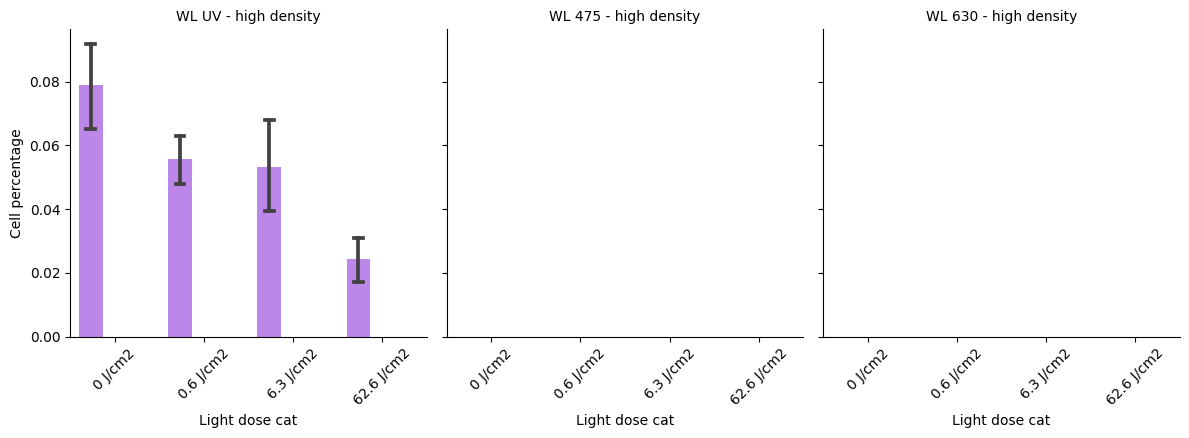

In [81]:
t = 60
data = pd.read_csv(os.path.join(output_path, "normalised_mitosis_counting_pix2pix.csv"))
data = data.loc[lambda data: data["frame"]==t]
g = sns.catplot(
    data, kind="bar",
    x="Light dose cat", y=plot_y_var, hue=wl_column,
    col=wl_column,
    palette=palette_colours,
    height=4, aspect=1, 
    order=hue_order, 
    hue_order=wl_order,
    errorbar=("ci", 95),  capsize=.1,
    col_order=wl_order
)
plt.tight_layout()
g.set_xticklabels(rotation=45)
g.set_titles("{col_name}")
g.savefig(os.path.join(output_path, "plots", f"barplot_cellpercentage_t{t}.pdf"), format="pdf", transparent=True)
plt.show()

## 2. Calculate the time point with the peak of identified mitoses

### 2.1. Estimate the cell size temporal distribution

In [ ]:
# We still use the data calculated in 1. We use the raw data, but one could used the smooth data.
data = data[data["processing"]=="Raw"].reset_index(drop=True)

## Estimate statistical parameters for the cell size temporal distribution
variable = "cell_size"
distribution_data = extract_gaussian_params(data, variable)
# We save the data so we can use it latter.
distribution_data.to_csv(os.path.join(output_path, "cell_size_statistics.csv"))

distribution_data = photofitt.utils.numerical_dose(distribution_data, column_name="Subcategory-02", power=light_power)
distribution_data = power_conversion(distribution_data, dose_column="Light dose", condition_col="Subcategory-02", condition_name="Synchro")
distribution_data.to_csv(os.path.join(output_path, "cell_size_statistics.csv"))

In [ ]:
# Load the computed data:
sys.path.append("/home/ocb/HardDrive_4TB/EGM/PHX/PhotoFITT/photofitt/display/")
from plots import info_wrt_peak, mitosis

distribution_data = pd.read_csv(os.path.join(output_path, "cell_size_statistics.csv"))
groups_comparison = np.unique(data["Subcategory-01"])

# Specified to ensure that all the plots have the same distribution of colors.
conditions = ['non-synchro-0 J/cm2', '0 J/cm2', '0.2 J/cm2',
             '0.3 J/cm2', '0.6 J/cm2', '1.3 J/cm2', '2.5 J/cm2',
             '5.0 J/cm2', '6.3 J/cm2', '31.3 J/cm2', 
             '62.6 J/cm2', '93.8 J/cm2', '125.1 J/cm2', '156.4 J/cm2', '187.7 J/cm2']
for c in groups_comparison:
    output_path_plots = os.path.join(output_path, "plots", c)
    os.makedirs(output_path_plots, exist_ok=True)
    # Obtain statistics about the data.
    aux = distribution_data[distribution_data["Subcategory-01"] == c].reset_index(drop=True)
    # aux["ratio"] = aux["GaussianMixtureCovariance_0"] / aux["GaussianMixtureCovariance_1"]
    # aux["subt_0"] = abs(aux["average"] - aux["GaussianMixtureMean_0"])
    # aux["subt_1"] = abs(aux["average"] - aux["GaussianMixtureMean_1"])
    mitosis(aux, output_path_plots, conditions, "average", hue="Light dose cat", figsize=(5, 4))
    # Display some of these statistics
    values = ["average", "derivative-average", "variance", 'GaussianMixtureMean_0', 'GaussianMixtureMean_1',
              'GaussianMixtureCovariance_0', 'GaussianMixtureCovariance_1']
    for v in values:
        print(v)
        display.conditions(aux, v, "Cell size {}".format(v), "Light dose cat", output_path_plots,
                        "size_{0}_{1}.png".format(v, c), style="Subcategory-01", hue_order=conditions,figsize=(5, 4))

### 2.2. Estimate the mitotic peak and the delay for each video.

In [62]:
# We still use the data calculated in 1. We use the smooth data this time, but one could used the raw data.
data = pd.read_csv(os.path.join(output_path, "normalised_mitosis_counting_pix2pix.csv"))
data = data.loc[lambda data: data["processing"]=='Averaged-kernel5']
plot_y_var = "Cell percentage"
# Integrate the information about the temporal peaks of mitosis
data_peaks = quantify_peaks(data, plot_y_var)

#### 2.2.1. Plot the distributions with violin plots

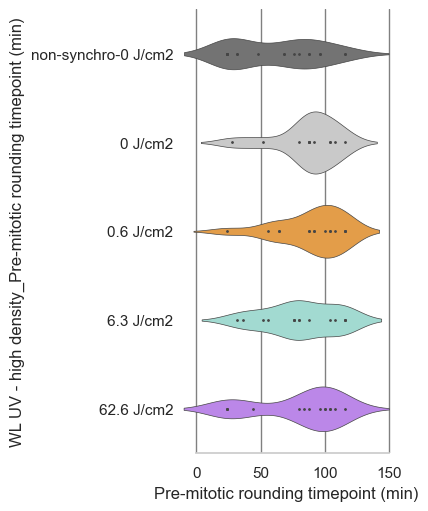

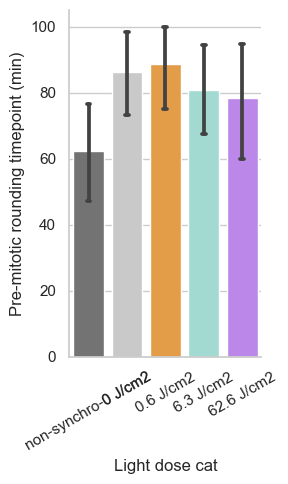

<Figure size 640x480 with 0 Axes>

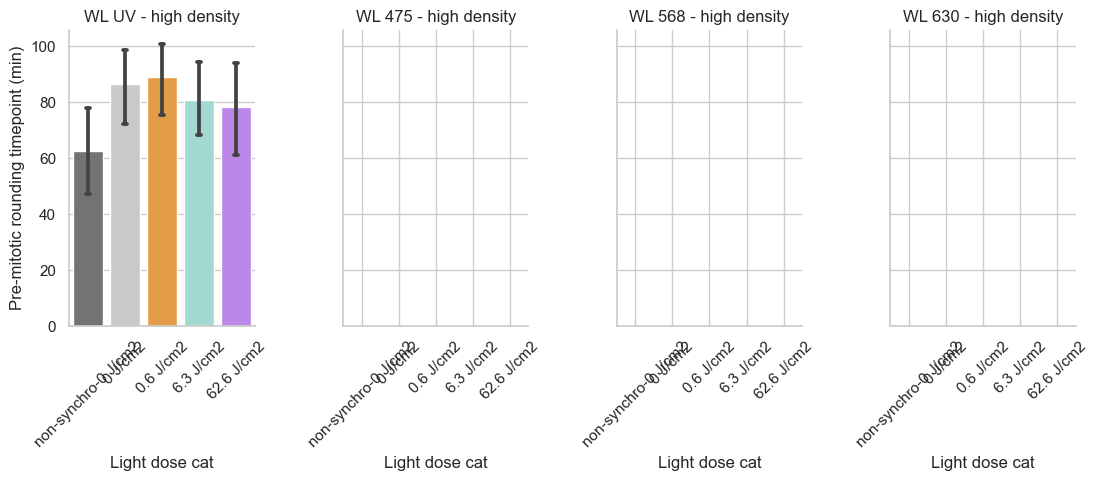

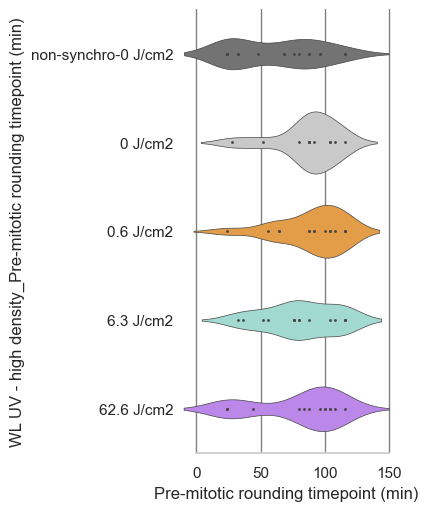

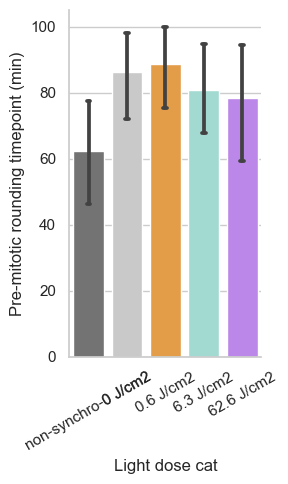

<Figure size 640x480 with 0 Axes>

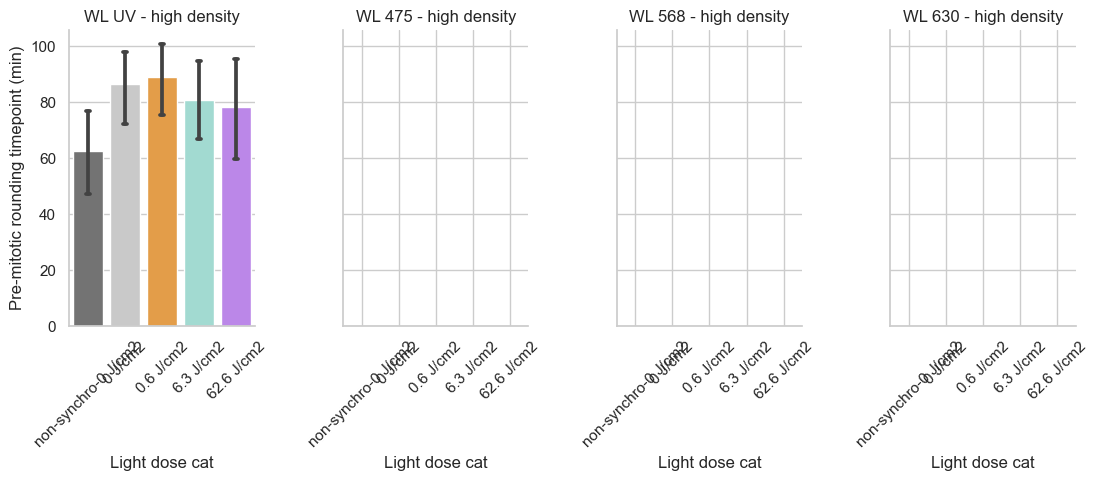

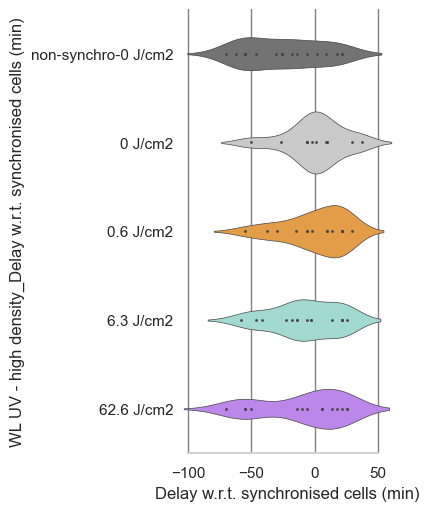

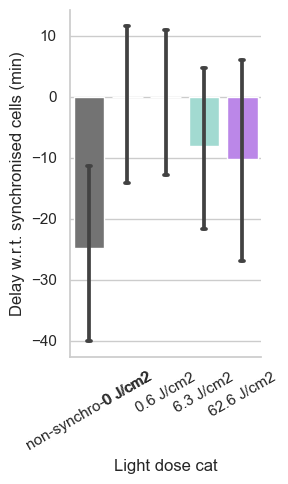

<Figure size 640x480 with 0 Axes>

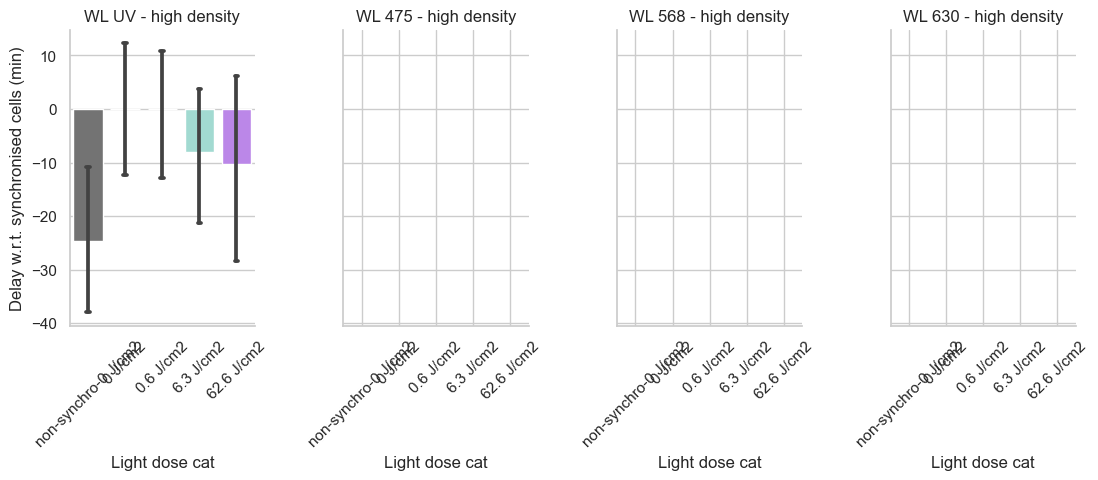

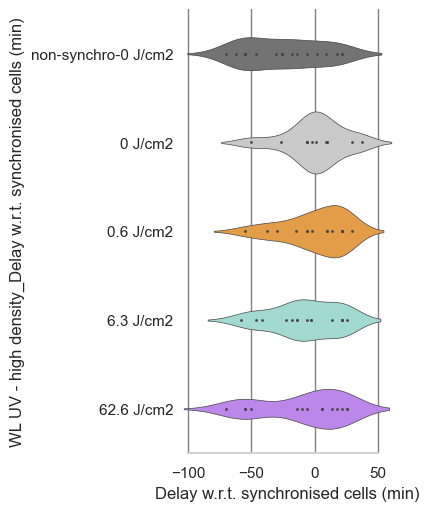

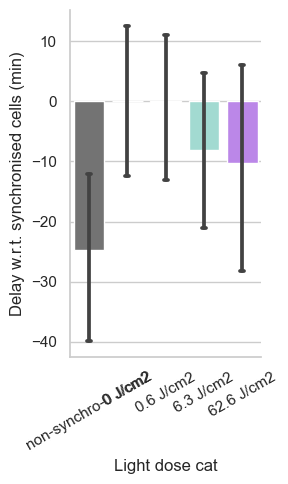

<Figure size 640x480 with 0 Axes>

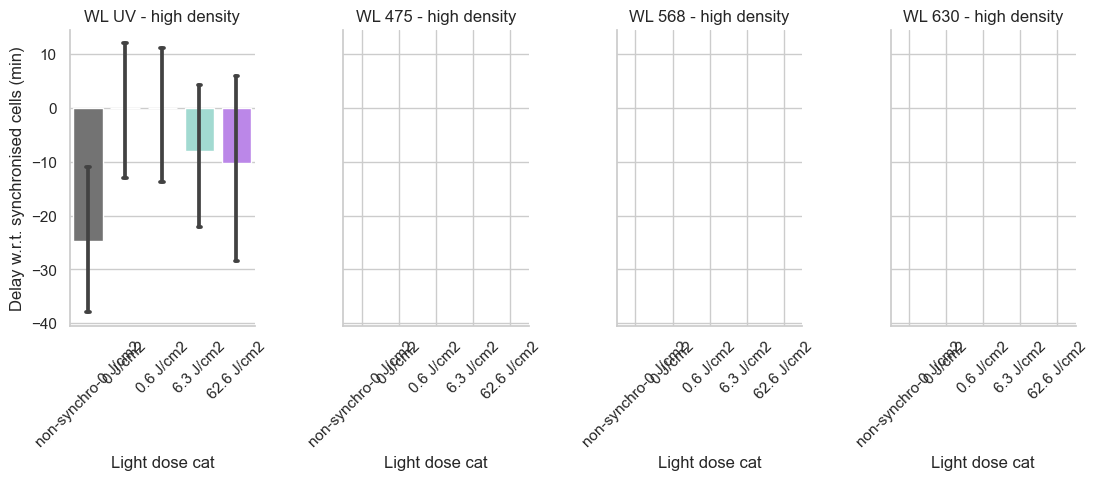

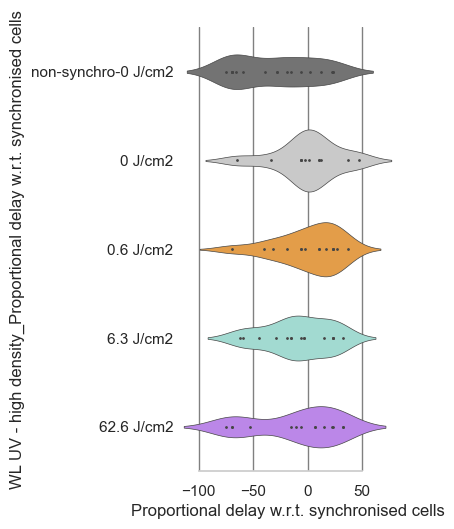

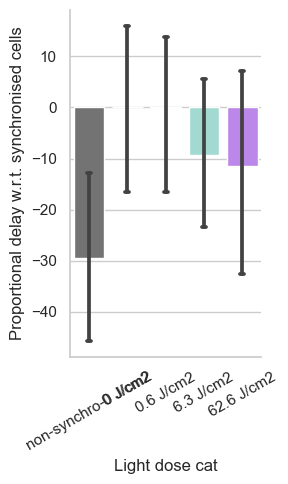

<Figure size 640x480 with 0 Axes>

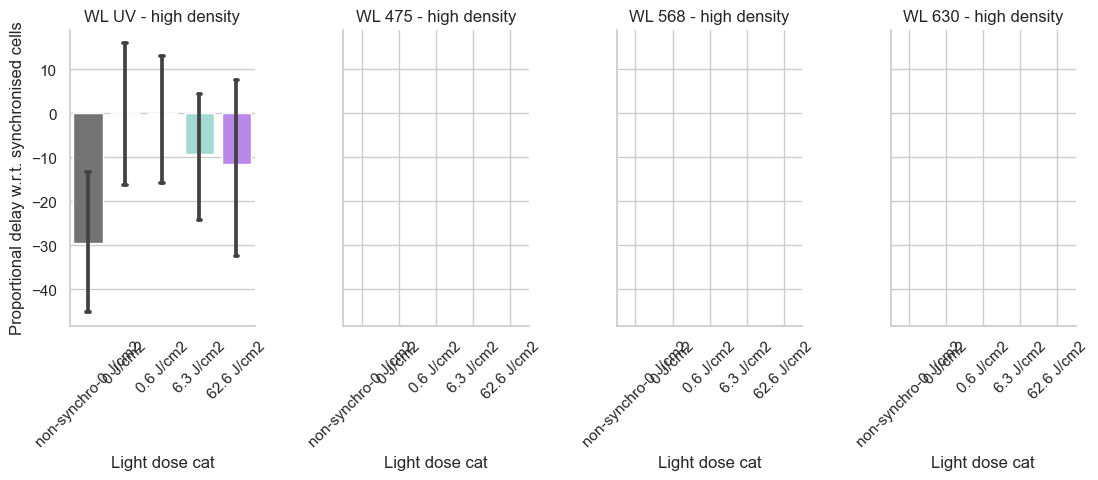

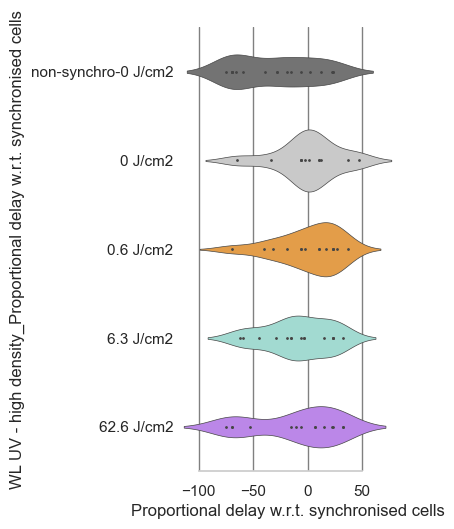

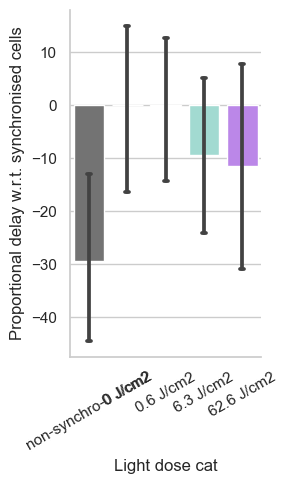

<Figure size 640x480 with 0 Axes>

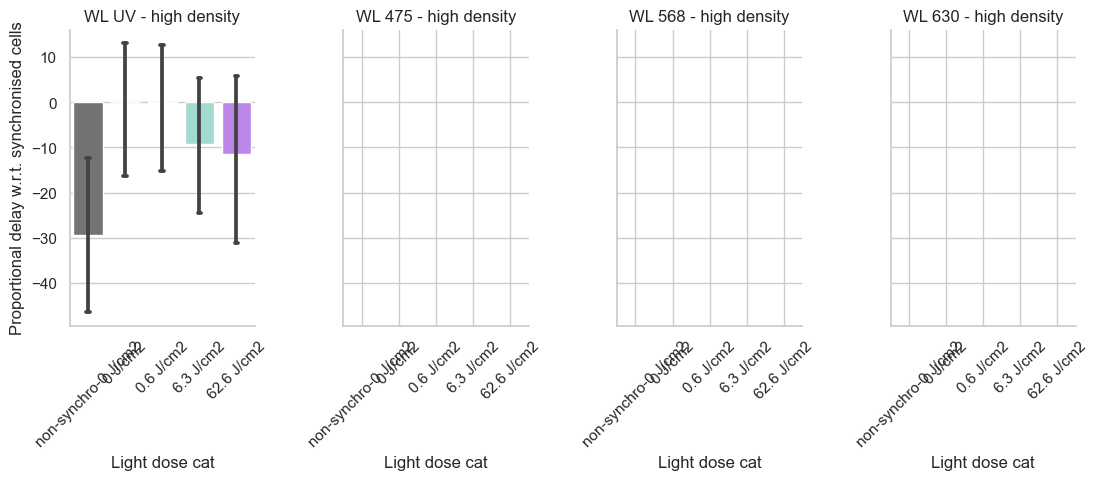

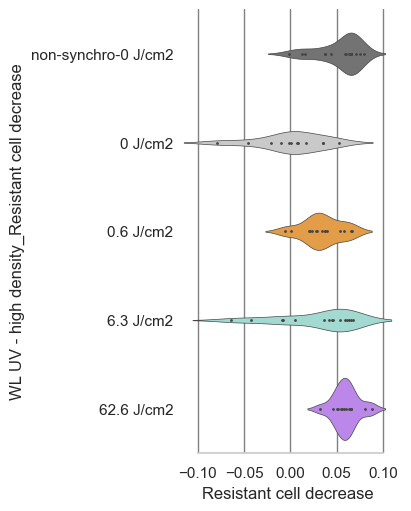

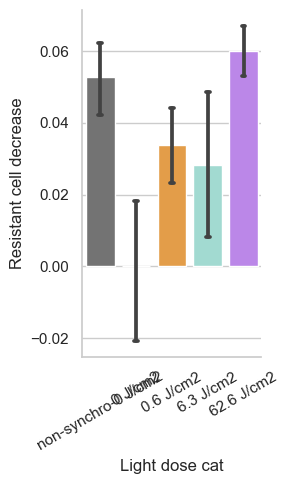

<Figure size 640x480 with 0 Axes>

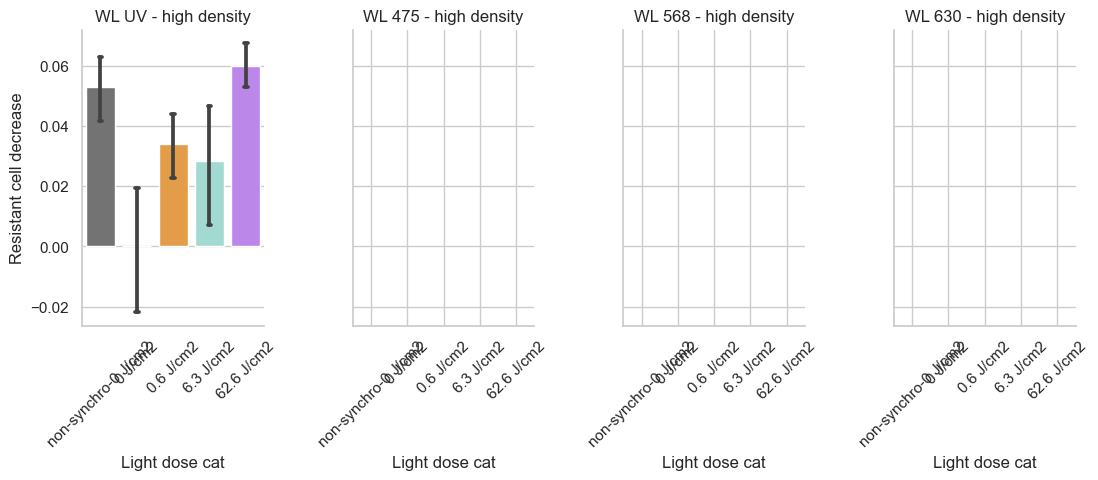

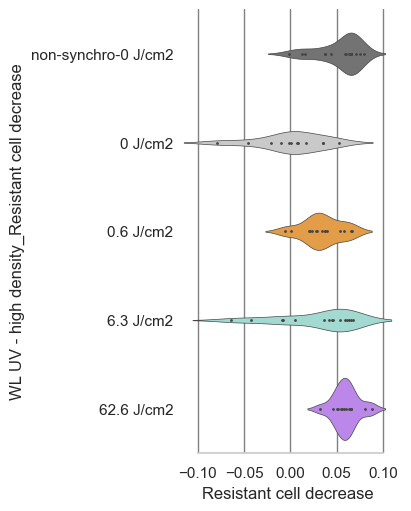

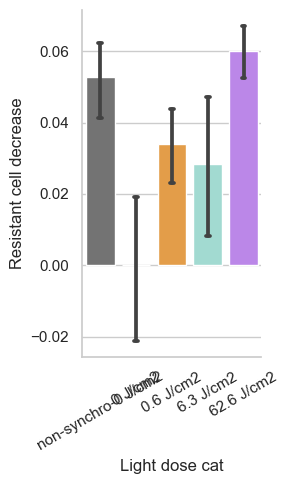

<Figure size 640x480 with 0 Axes>

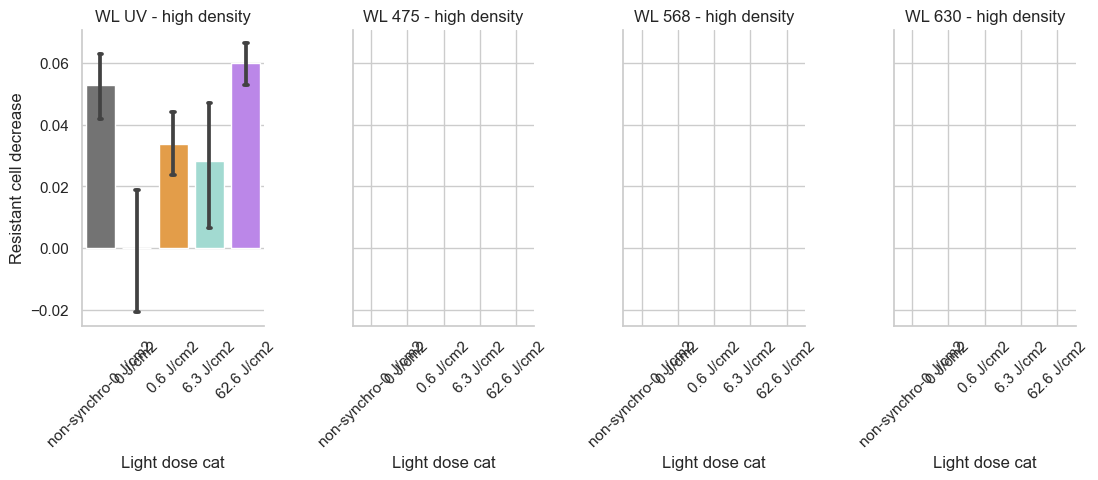

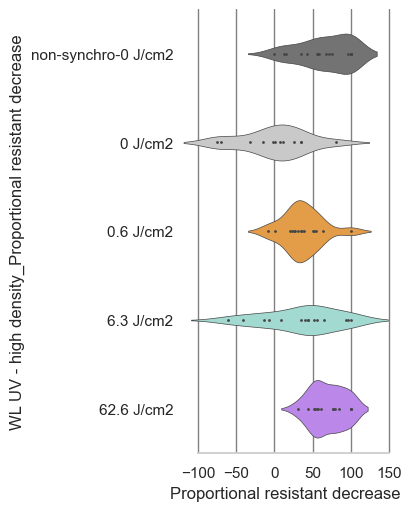

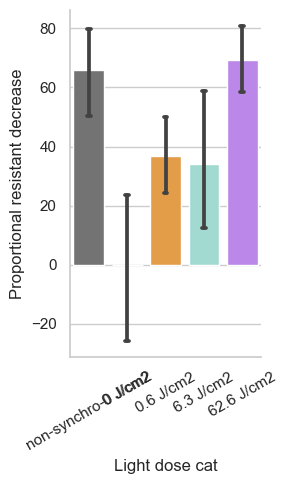

<Figure size 640x480 with 0 Axes>

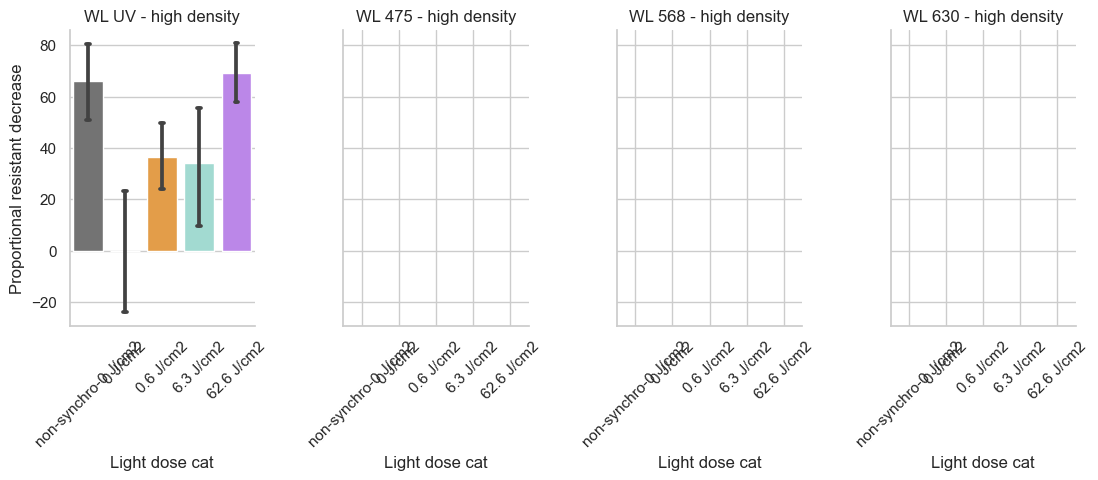

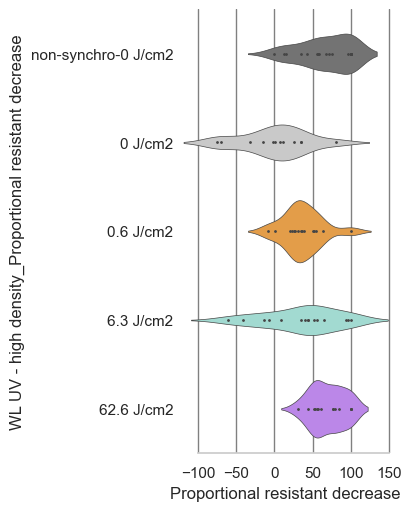

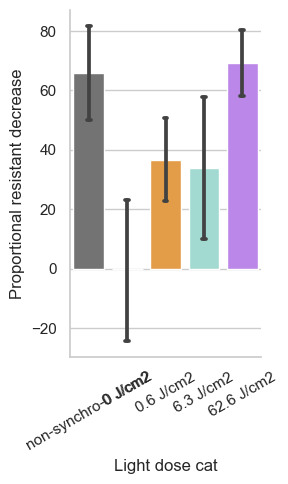

<Figure size 640x480 with 0 Axes>

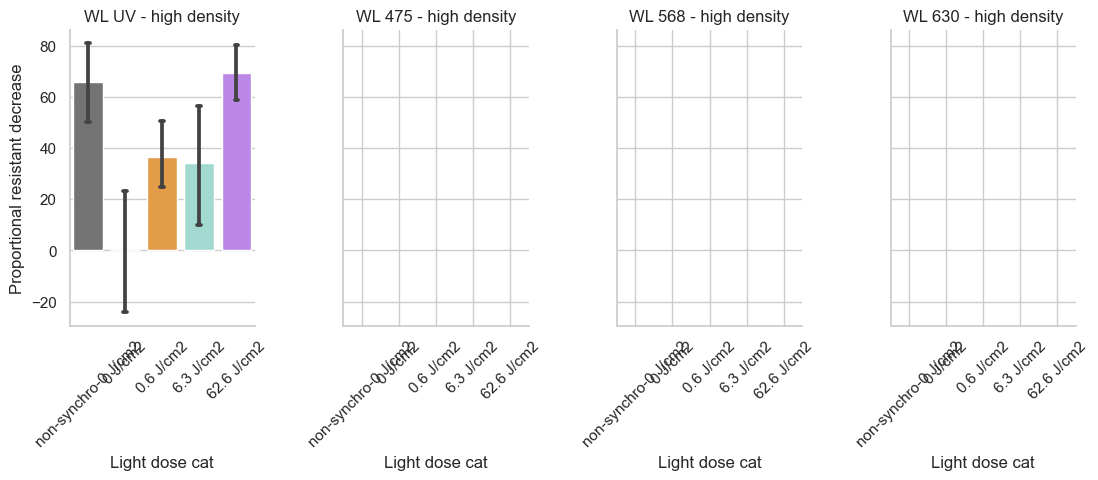

In [10]:
#### Show each distribution with both violins and points
import matplotlib.pyplot as plt

## Rename the columns to get the proper naming in the plots
data_peaks = data_peaks.rename(columns={'peak_time': 'Pre-mitotic rounding timepoint (min)', 
                            'delay_synchro': 'Delay w.r.t. synchronised cells (min)',
                           'proportional_delay_synchro': 'Proportional delay w.r.t. synchronised cells'})

x_var = [ 'Pre-mitotic rounding timepoint (min)', "Delay w.r.t. synchronised cells (min)",
         "Proportional delay w.r.t. synchronised cells", "Resistant cell decrease",
         "Proportional resistant decrease"]

hue_order = ['non-synchro-0 J/cm2', '0 J/cm2', '0.6 J/cm2', '6.3 J/cm2','62.6 J/cm2']
palette_colours = ['#737373', '#C9C9C9', '#FC9F30', '#99E3D7', '#BC77F8']
wl_order = ['WL UV - high density', 'WL 475 - high density', 'WL 568 - high density', 'WL 630 - high density']
# Estimate the ligth dose
light_power = 6.255662 # fixed power value according to our microscope
data_peaks = photofitt.utils.numerical_dose(data_peaks, column_name="Subcategory-02", power=light_power)
data_peaks = power_conversion(data_peaks, dose_column="Light dose", condition_col="Subcategory-02", condition_name="Synchro")

fig_format = ["png", "pdf"]
wl = np.unique(data_peaks["Subcategory-01"])

fig_format = ["png", "pdf"]
for x in x_var:
    for f in fig_format:
        for w in wl:
            data_peaks_w = data_peaks.loc[lambda data_peaks: data_peaks["Subcategory-01"]==w]
            name = f"{w}_{x}.{f}"# name we want to give to the plot
            new_name = f"peaktime_violin_horizontal_exposure_time{name}"
     #       display.violinplots_horizontal(data_peaks,"Subcategory-02", x, output_path, new_name, hue_order,
     #                              palette=sns.color_palette("CMRmap_r", 17))
            display.violinplots_horizontal(data_peaks_w,'Light dose cat', x,
                                           os.path.join(output_path, "plots"),
                                           new_name, hue_order,
                                           palette=palette_colours, #sns.color_palette("CMRmap_r", 17),
                                           ylabel=f"{w}_{x}")
            ## Bar plots
            name = f"{w}_{x}.{f}"# name we want to give to the plot
            new_name = f"barplot_{name}"
            fig = plt.figure(figsize=(3,5))
            g = sns.barplot(data_peaks_w, x='Light dose cat', y=x,
                        palette=palette_colours, #sns.color_palette("CMRmap_r", 17),
                        errorbar=("ci", 95),  capsize=.1,
                        order=hue_order)
            plt.setp(g.get_xticklabels(), rotation=30)
            plt.tight_layout()
            fig.savefig(os.path.join(output_path, "plots", new_name), format=f, transparent=True)
            plt.show()
        
        # Plot all barplots together
        name = f"{x}.{f}"# name we want to give to the plot
        new_name = f"barplot_all_{name}"
        
        fig = plt.figure()
        g = sns.catplot(
            data_peaks, kind="bar",
            x='Light dose cat', y=x,
            col="Subcategory-01",
            palette=palette_colours, #sns.color_palette("CMRmap_r", 17),
            height=4, aspect=0.7, 
            order=hue_order, 
            errorbar=("ci", 95),  capsize=.1,
            col_order=wl_order
        )
        plt.tight_layout()
        g.set_xticklabels(rotation=45)
        g.set_titles("{col_name}")
        g.savefig(os.path.join(output_path, "plots", new_name), format=f, transparent=True)
        plt.show()


## 3. Calculate the temporal dynamics and distorsions of cell activity.

In [57]:
images_path = "/home/ocb/HardDrive_4TB/EGM/PHX/DATA/DOWNSAMPLE/HELA-SYNCHRO/scaled_1.5709_results/"
output_path =  "/home/ocb/HardDrive_4TB/EGM/PHX/ANALYSIS/HELA-SYNCHRO/NEW-ACTIVITY/"
output_path = "/Users/esti/Documents/PROYECTOS/PHX/DOCS/MANUSCRIPT/CODE/data/synchro"
## Parameters for activity method estimation
method="intensity"
#folder = "activity_clahe-normalised-all-{}".format(method)
folder="publication-data"

condition="unsynchro"
os.makedirs(os.path.join(output_path, folder),exist_ok=True)

### 3.1 Quantify cell activity and save the values in a .csv file

In [ ]:
from photofitt.analysis import extract_activity

## The function will store the values as it is calculating them to avoid losing tehm in case the system crashes.
if not os.path.exists(os.path.join(output_path, folder)):
    os.mkdir(os.path.join(output_path, folder))

activity_metrics = extract_activity(images_path, method=method, save_steps=False, enhance_contrast=True,
                                            output_path=os.path.join(output_path, folder), condition=None)
## Save the results
activity_metrics.to_csv(os.path.join(output_path, folder, "data_activity_{0}.csv".format(method)))

CHO_unsync_630-live-01-Scene-32-P2-A04.tif
CHO_unsync_630-live-01-Scene-33-P6-A04.tif
CHO_unsync_630-live-01-Scene-34-P1-A04.tif
CHO_unsync_630-live-01-Scene-35-P4-A04.tif
CHO_unsync_630-live-01-Scene-36-P7-A04.tif
CHO_unsync_630-live-01-Scene-37-P8-A04.tif
CHO_unsync_630-live-01-Scene-38-P3-A04.tif
CHO_unsync_630-live-01-Scene-39-P5-A04.tif
CHO_unsync_630-live-01-Scene-40-P10-A04.tif
['CHO_unsync_630-live-01-Scene-61-P7-B02.tif', 'CHO_unsync_630-live-01-Scene-62-P1-B02.tif', 'CHO_unsync_630-live-01-Scene-63-P5-B02.tif', 'CHO_unsync_630-live-01-Scene-64-P3-B02.tif', 'CHO_unsync_630-live-01-Scene-65-P8-B02.tif', 'CHO_unsync_630-live-01-Scene-66-P9-B02.tif', 'CHO_unsync_630-live-01-Scene-67-P10-B02.tif', 'CHO_unsync_630-live-01-Scene-68-P4-B02.tif', 'CHO_unsync_630-live-01-Scene-69-P2-B02.tif', 'CHO_unsync_630-live-01-Scene-70-P6-B02.tif']
CHO_unsync_630-live-01-Scene-61-P7-B02.tif
CHO_unsync_630-live-01-Scene-62-P1-B02.tif
CHO_unsync_630-live-01-Scene-63-P5-B02.tif
CHO_unsync_630-live-0

CHO_unsync_UV-live-01-Scene-66-P3-B02.tif
CHO_unsync_UV-live-01-Scene-67-P6-B02.tif
CHO_unsync_UV-live-01-Scene-68-P5-B02.tif
CHO_unsync_UV-live-01-Scene-69-P8-B02.tif
CHO_unsync_UV-live-01-Scene-70-P9-B02.tif
['CHO_unsync_UV-live-01-Scene-51-P9-B03.tif', 'CHO_unsync_UV-live-01-Scene-52-P4-B03.tif', 'CHO_unsync_UV-live-01-Scene-53-P7-B03.tif', 'CHO_unsync_UV-live-01-Scene-54-P3-B03.tif', 'CHO_unsync_UV-live-01-Scene-55-P10-B03.tif', 'CHO_unsync_UV-live-01-Scene-56-P8-B03.tif', 'CHO_unsync_UV-live-01-Scene-57-P6-B03.tif', 'CHO_unsync_UV-live-01-Scene-58-P2-B03.tif', 'CHO_unsync_UV-live-01-Scene-59-P1-B03.tif', 'CHO_unsync_UV-live-01-Scene-60-P5-B03.tif']
CHO_unsync_UV-live-01-Scene-51-P9-B03.tif
CHO_unsync_UV-live-01-Scene-52-P4-B03.tif
CHO_unsync_UV-live-01-Scene-53-P7-B03.tif
CHO_unsync_UV-live-01-Scene-54-P3-B03.tif
CHO_unsync_UV-live-01-Scene-55-P10-B03.tif
CHO_unsync_UV-live-01-Scene-56-P8-B03.tif
CHO_unsync_UV-live-01-Scene-57-P6-B03.tif
CHO_unsync_UV-live-01-Scene-58-P2-B03.tif
C

CHO_unsync_UV-live-01-Scene-62-P7-B02.tif
CHO_unsync_UV-live-01-Scene-63-P2-B02.tif
CHO_unsync_UV-live-01-Scene-64-P4-B02.tif
CHO_unsync_UV-live-01-Scene-65-P3-B02.tif
CHO_unsync_UV-live-01-Scene-66-P1-B02.tif
CHO_unsync_UV-live-01-Scene-67-P6-B02.tif
CHO_unsync_UV-live-01-Scene-68-P5-B02.tif
CHO_unsync_UV-live-01-Scene-69-P8-B02.tif
CHO_unsync_UV-live-01-Scene-70-P9-B02.tif
['CHO_unsync_UV-live-01-Scene-51-P4-B03.tif', 'CHO_unsync_UV-live-01-Scene-52-P6-B03.tif', 'CHO_unsync_UV-live-01-Scene-53-P7-B03.tif', 'CHO_unsync_UV-live-01-Scene-54-P3-B03.tif', 'CHO_unsync_UV-live-01-Scene-55-P9-B03.tif', 'CHO_unsync_UV-live-01-Scene-56-P8-B03.tif', 'CHO_unsync_UV-live-01-Scene-57-P2-B03.tif', 'CHO_unsync_UV-live-01-Scene-58-P10-B03.tif', 'CHO_unsync_UV-live-01-Scene-59-P1-B03.tif', 'CHO_unsync_UV-live-01-Scene-60-P5-B03.tif']
CHO_unsync_UV-live-01-Scene-51-P4-B03.tif
CHO_unsync_UV-live-01-Scene-52-P6-B03.tif
CHO_unsync_UV-live-01-Scene-53-P7-B03.tif
CHO_unsync_UV-live-01-Scene-54-P3-B03.tif
CH

unsync_CHO_day_475_snap-prelive-02-Scene-42-P9-B04.tif
unsync_CHO_day_475_snap-prelive-02-Scene-43-P2-B04.tif
unsync_CHO_day_475_snap-prelive-02-Scene-44-P1-B04.tif
unsync_CHO_day_475_snap-prelive-02-Scene-45-P4-B04.tif
unsync_CHO_day_475_snap-prelive-02-Scene-46-P5-B04.tif
unsync_CHO_day_475_snap-prelive-02-Scene-47-P6-B04.tif
unsync_CHO_day_475_snap-prelive-02-Scene-48-P8-B04.tif
unsync_CHO_day_475_snap-prelive-02-Scene-49-P3-B04.tif
unsync_CHO_day_475_snap-prelive-02-Scene-50-P7-B04.tif
['unsync_CHO_day_475_snap-prelive-02-Scene-01-P1-A01.tif', 'unsync_CHO_day_475_snap-prelive-02-Scene-02-P5-A01.tif', 'unsync_CHO_day_475_snap-prelive-02-Scene-03-P2-A01.tif', 'unsync_CHO_day_475_snap-prelive-02-Scene-04-P9-A01.tif', 'unsync_CHO_day_475_snap-prelive-02-Scene-05-P6-A01.tif', 'unsync_CHO_day_475_snap-prelive-02-Scene-06-P3-A01.tif', 'unsync_CHO_day_475_snap-prelive-02-Scene-07-P4-A01.tif', 'unsync_CHO_day_475_snap-prelive-02-Scene-08-P10-A01.tif', 'unsync_CHO_day_475_snap-prelive-02-Sce

CHO_unsync_UV-live-01-Scene-52-P6-B03.tif
CHO_unsync_UV-live-01-Scene-53-P7-B03.tif
CHO_unsync_UV-live-01-Scene-54-P3-B03.tif
CHO_unsync_UV-live-01-Scene-55-P9-B03.tif
CHO_unsync_UV-live-01-Scene-56-P8-B03.tif
CHO_unsync_UV-live-01-Scene-57-P2-B03.tif
CHO_unsync_UV-live-01-Scene-58-P10-B03.tif
CHO_unsync_UV-live-01-Scene-59-P1-B03.tif
CHO_unsync_UV-live-01-Scene-60-P5-B03.tif
['CHO_unsync_UV-live-01-Scene-41-P9-B04.tif', 'CHO_unsync_UV-live-01-Scene-42-P10-B04.tif', 'CHO_unsync_UV-live-01-Scene-43-P5-B04.tif', 'CHO_unsync_UV-live-01-Scene-44-P2-B04.tif', 'CHO_unsync_UV-live-01-Scene-45-P8-B04.tif', 'CHO_unsync_UV-live-01-Scene-46-P7-B04.tif', 'CHO_unsync_UV-live-01-Scene-47-P4-B04.tif', 'CHO_unsync_UV-live-01-Scene-48-P1-B04.tif', 'CHO_unsync_UV-live-01-Scene-49-P3-B04.tif', 'CHO_unsync_UV-live-01-Scene-50-P6-B04.tif']
CHO_unsync_UV-live-01-Scene-41-P9-B04.tif
CHO_unsync_UV-live-01-Scene-42-P10-B04.tif
CHO_unsync_UV-live-01-Scene-43-P5-B04.tif
CHO_unsync_UV-live-01-Scene-44-P2-B04.tif


### 3.2 Display the results
If the previous cell was finished, a csv file is stored with all the data. This csv file is loaded here and used for the rest of the analysis.

TIME 420


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Index(['Light dose cat', 'video_name', 'mean Cumulative mean activity',
       'Subcategory-00 mean Cumulative mean activity', 'Subcategory-00',
       'difference_per_video_name', 'difference_per_Subcategory-00',
       'proportional_difference_per_video_name',
       'proportional_difference_per_Subcategory-00', 'Subcategory-01'],
      dtype='object')


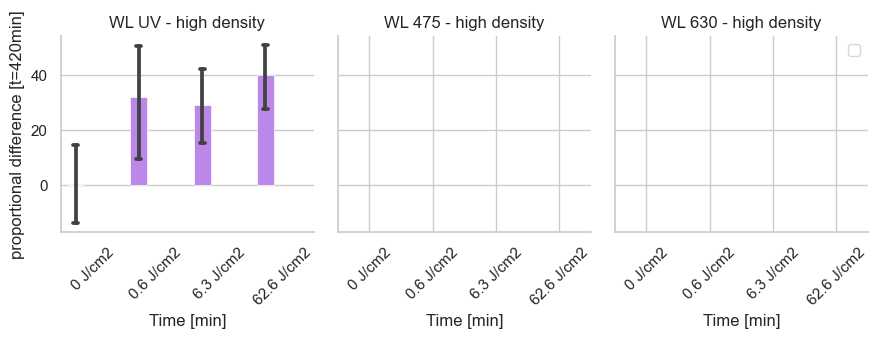

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


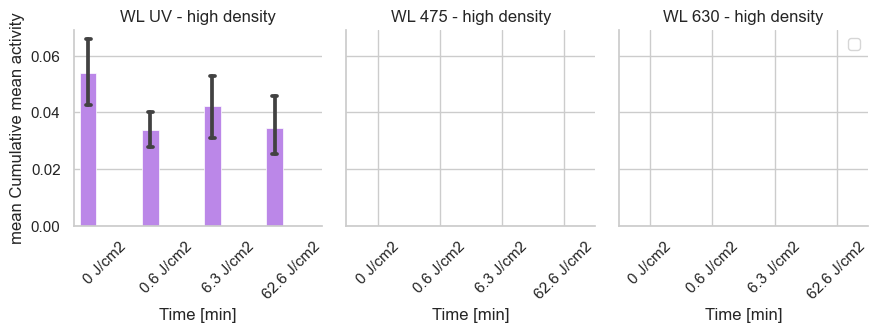

TIME 476


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Index(['Light dose cat', 'video_name', 'mean Cumulative mean activity',
       'Subcategory-00 mean Cumulative mean activity', 'Subcategory-00',
       'difference_per_video_name', 'difference_per_Subcategory-00',
       'proportional_difference_per_video_name',
       'proportional_difference_per_Subcategory-00', 'Subcategory-01'],
      dtype='object')


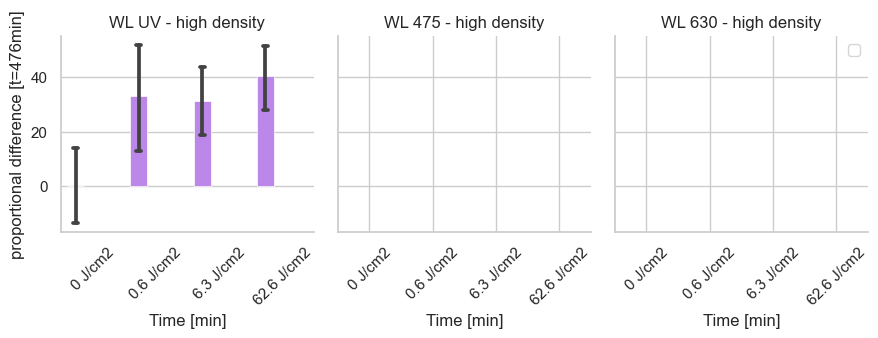

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


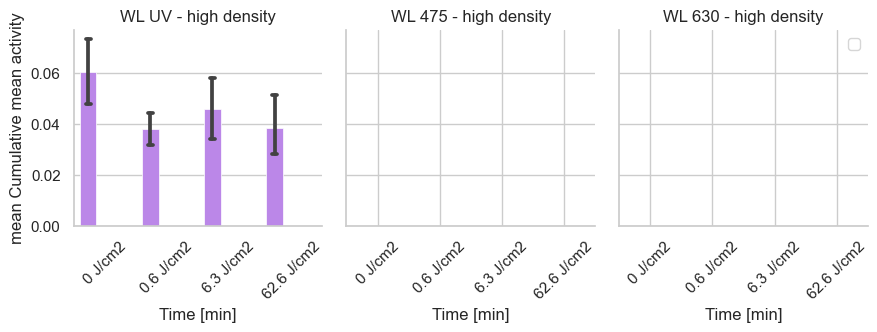

In [58]:
for t in [420, 476]:
    print(f"TIME {t}")
    activity_metrics = pd.read_csv(os.path.join(output_path, folder, "data_activity_{0}.csv".format(method)))
    ## Barplots on activity to compare conditions
    y = "mean activity"
    activity_dataframe, activity = cumulative_activity(activity_metrics, y, use_starting_point="None", starting_point=1)
    
    # Estimate the ligth dose
    light_power = 6.255662 # fixed power value according to our microscope
    activity = photofitt.utils.numerical_dose(activity, column_name="Subcategory-02", power=light_power)
    activity_dataframe = photofitt.utils.numerical_dose(activity_dataframe, column_name="Subcategory-02", power=light_power)
    
    if folder=="unsynchro":
        activity = photofitt.utils.power_conversion(activity, dose_column="Light dose", condition_col="Subcategory-02", condition_name='control-00ms')
        activity_dataframe = photofitt.utils.power_conversion(activity_dataframe, dose_column="Light dose", condition_col="Subcategory-02", condition_name='control-00ms')
    else:
        activity = photofitt.utils.power_conversion(activity, dose_column="Light dose", condition_col="Subcategory-02", condition_name='Control-sync')
        activity_dataframe = photofitt.utils.power_conversion(activity_dataframe, dose_column="Light dose", condition_col="Subcategory-02", condition_name='Control-sync')
    activity = activity.loc[lambda activity: activity["frame"]==t]
    
    variable = 'Cumulative mean activity'
    reference_category='0 J/cm2'
    reference_variable="Light dose cat"
    unique_id_var = "video_name"
    grouping_variable="Subcategory-00"
    
    activity_diff = estimate_proportional_deviations(activity,
                                                     variable,
                                                     reference_category=reference_category,
                                                     reference_variable=reference_variable,
                                                     unique_id_var=unique_id_var,
                                                     grouping_variable=grouping_variable,
                                                     add_columns=["Subcategory-01", unique_id_var])
    print(activity_diff.columns)
    
    hue_order = ['0 J/cm2', '0.6 J/cm2', '6.3 J/cm2', '62.6 J/cm2']
    palette_colours = ['#BC77F8', '#30C7A6', '#FF7848']
    wl_order = ['WL UV - high density', 'WL 475 - high density','WL 630 - high density']
    wl_column = "Subcategory-01"
    g = sns.catplot(
        activity_diff, kind="bar",
        x=reference_variable, y=f"proportional_difference_per_{unique_id_var}", col=wl_column,
        hue=wl_column,
        height=3, aspect=1,
        order=hue_order,
        col_order=wl_order,
        palette=palette_colours,
        errorbar=("ci", 95),  capsize=.08, linewidth=0.5,
        hue_order=wl_order, legend=False
    )
    plt.tight_layout()
    g.fig.get_axes()[-1].legend(loc='upper right')
    g.set_xticklabels(rotation=45)
    g.set(xlabel="Time [min]", ylabel=f"proportional difference [t={t}min]")
    g.set_titles("{col_name}")
    g.savefig(os.path.join(output_path, folder, f"barplots_{variable}_differences_t{t}.pdf"), format="pdf", transparent=True)
    plt.show()

    g = sns.catplot(
        activity_diff, kind="bar",
        x=reference_variable, y="mean Cumulative mean activity", col=wl_column,
        hue=wl_column,
        height=3, aspect=1,
        order=hue_order,
        col_order=wl_order,
        palette=palette_colours,
        errorbar=("ci", 95),  capsize=.08, linewidth=0.5,
        hue_order=wl_order, legend=False
    )
    plt.tight_layout()
    g.fig.get_axes()[-1].legend(loc='upper right')
    g.set_xticklabels(rotation=45)
    g.set(xlabel="Time [min]", ylabel="mean Cumulative mean activity")
    g.set_titles("{col_name}")
    g.savefig(os.path.join(output_path, folder, f"barplots_{variable}_t{t}.pdf"), format="pdf", transparent=True)
    plt.show()

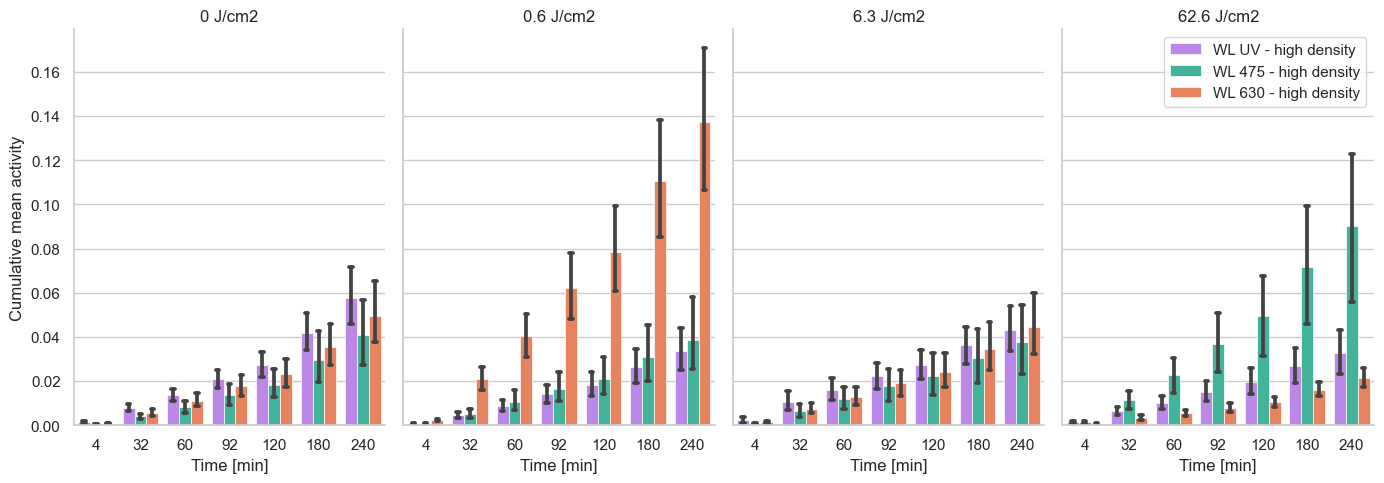

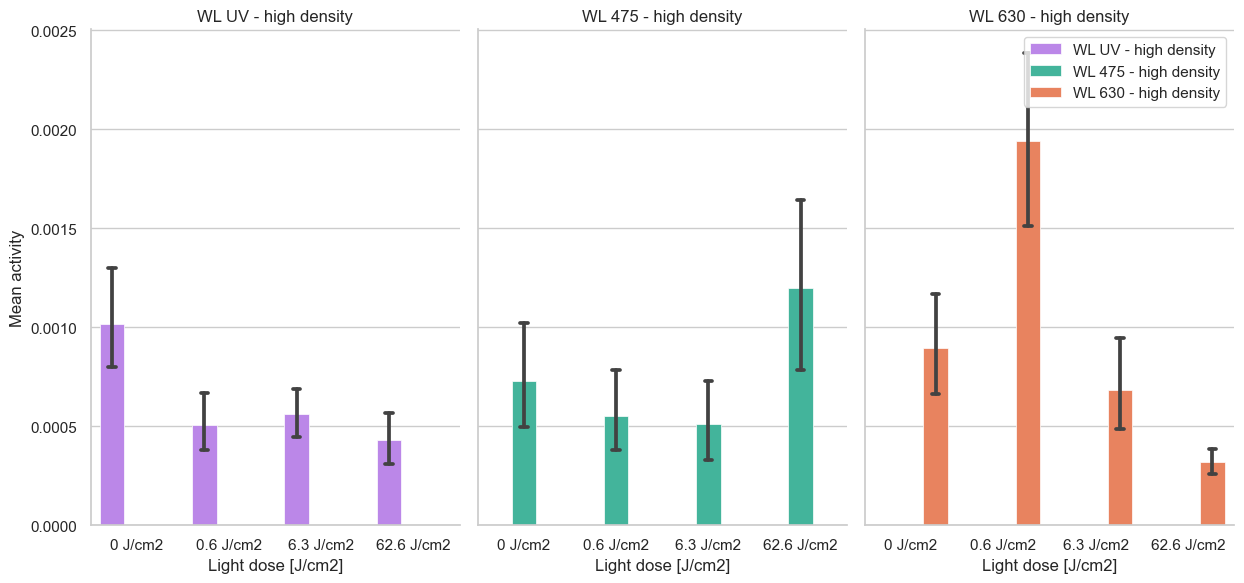

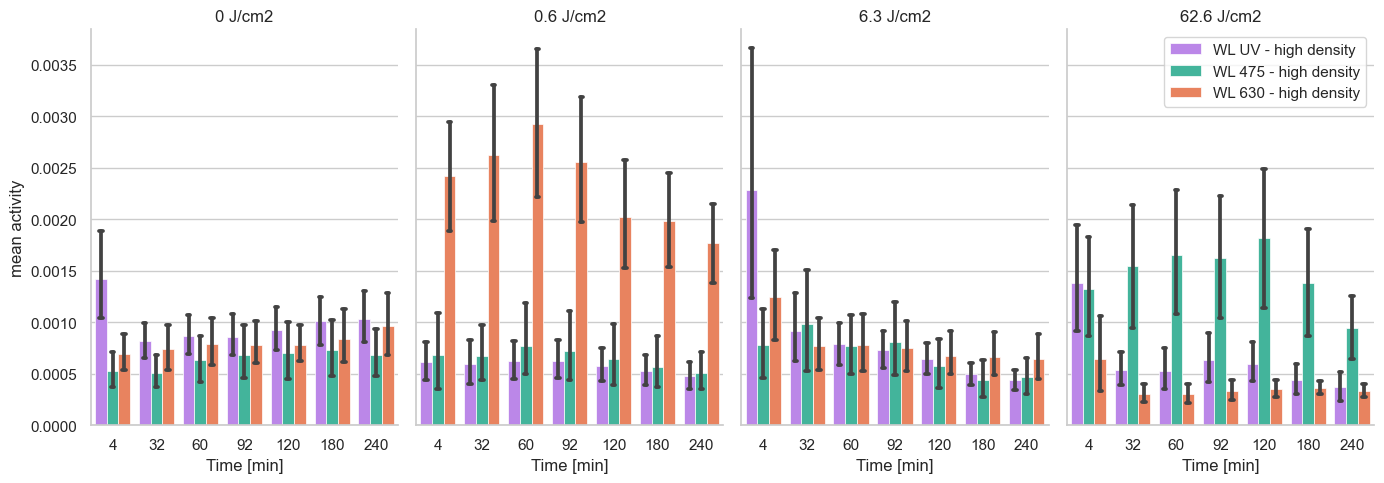

In [29]:
## Save the results
activity_metrics = pd.read_csv(os.path.join(output_path, folder, "data_activity_{0}.csv".format(method)))

## Barplots on activity to compare conditions
y = "mean activity"
activity_dataframe, activity = cumulative_activity(activity_metrics, y, use_starting_point="None", starting_point=1)

# Estimate the ligth dose
light_power = 6.255662 # fixed power value according to our microscope
activity_metrics = photofitt.utils.numerical_dose(activity_metrics, column_name="Subcategory-02", power=light_power)
activity_dataframe = photofitt.utils.numerical_dose(activity_dataframe, column_name="Subcategory-02", power=light_power)

if folder=="unsynchro":
    activity_metrics = photofitt.utils.power_conversion(activity_metrics, dose_column="Light dose", condition_col="Subcategory-02", condition_name='control-00ms')
    activity_dataframe = photofitt.utils.power_conversion(activity_dataframe, dose_column="Light dose", condition_col="Subcategory-02", condition_name='control-00ms')
else:
    activity_metrics = photofitt.utils.power_conversion(activity_metrics, dose_column="Light dose", condition_col="Subcategory-02", condition_name='Control-sync')
    activity_dataframe = photofitt.utils.power_conversion(activity_dataframe, dose_column="Light dose", condition_col="Subcategory-02", condition_name='Control-sync')

y_var = f"Cumulative {y}"

hue_order = ['0 J/cm2', '0.6 J/cm2', '6.3 J/cm2', '62.6 J/cm2']
palette_colours = ['#C9C9C9', '#FC9F30', '#99E3D7', '#BC77F8']

palette_colours = ['#BC77F8', '#30C7A6', '#FF7848']

wl_order = ['WL UV - high density', 'WL 475 - high density','WL 630 - high density']
g = sns.catplot(
    activity, kind="bar",
    x="frame", y=y_var, col="Light dose cat",
    hue="Subcategory-01",
    height=5, aspect=0.7,
    order= [4, 32, 60, 92, 120, 180, 240],
    col_order=hue_order,
    palette=palette_colours,
    errorbar=("ci", 95),  capsize=.08, linewidth=0.5,
    hue_order=wl_order, legend=False
)
plt.tight_layout()
g.fig.get_axes()[-1].legend(loc='upper right')
g.set_xticklabels(rotation=0)
g.set(xlabel="Time [min]")
g.set_titles("{col_name}")
g.savefig(os.path.join(output_path, folder, f"barplots_{y_var}.pdf"), format="pdf", transparent=True)

plt.show()

g = sns.catplot(
    activity_dataframe, kind="bar",
    x="Light dose cat", y="Mean activity", col="Subcategory-01",
    hue="Subcategory-01",
    height=6, aspect=0.7,
    order= hue_order,
    col_order=wl_order,
    hue_order=wl_order,
    palette=palette_colours,
    errorbar=("ci", 95),  capsize=.08, linewidth=0.5,
    legend=False
)
plt.tight_layout()
g.fig.get_axes()[-1].legend(loc='upper right')
g.set_xticklabels(rotation=0)
g.set(xlabel="Light dose [J/cm2]")
g.set_titles("{col_name}")
g.savefig(os.path.join(output_path, folder, f"barplots_total_mean_activity.pdf"), format="pdf", transparent=True)
plt.show()

g = sns.catplot(
    activity, kind="bar",
    x="frame", y=y, col="Light dose cat",
    hue="Subcategory-01",
    height=5, aspect=0.7,
    order= [4, 32, 60, 92, 120, 180, 240],
    col_order=hue_order,
    palette=palette_colours,
    errorbar=("ci", 95),  capsize=.08, linewidth=0.5,
    hue_order=wl_order, legend=False
)
plt.tight_layout()
g.fig.get_axes()[-1].legend(loc='upper right')
g.set_xticklabels(rotation=0)
g.set_titles("{col_name}")
g.set(xlabel="Time [min]")
g.savefig(os.path.join(output_path, folder, f"barplots_{y}.pdf"), format="pdf", transparent=True)
plt.show()

#activity_metrics

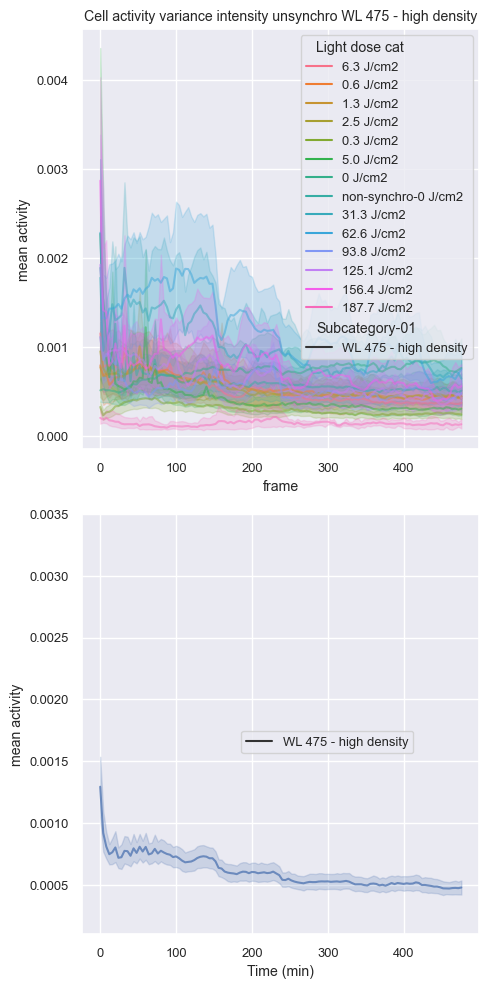

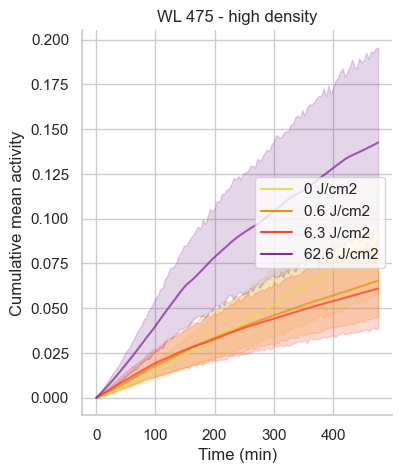

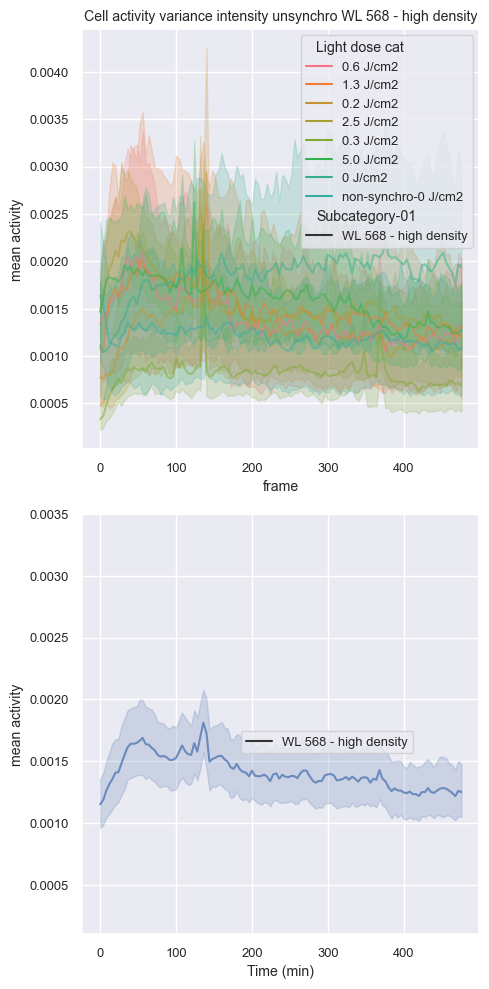

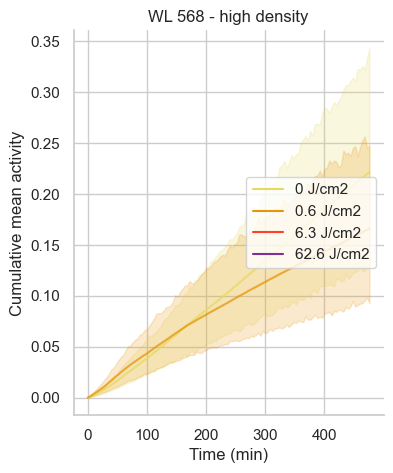

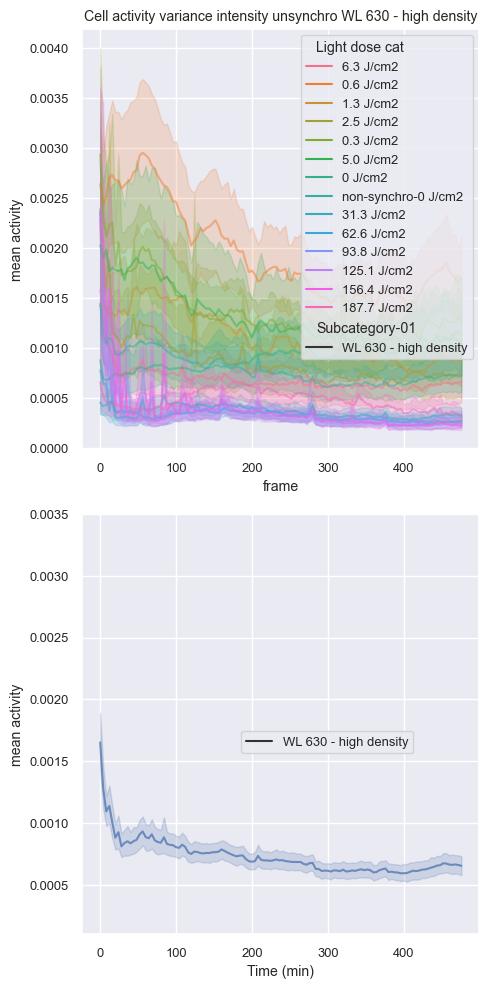

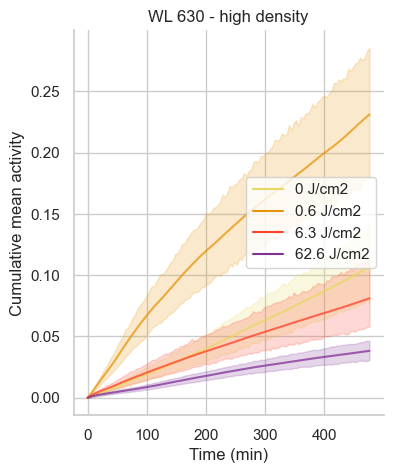

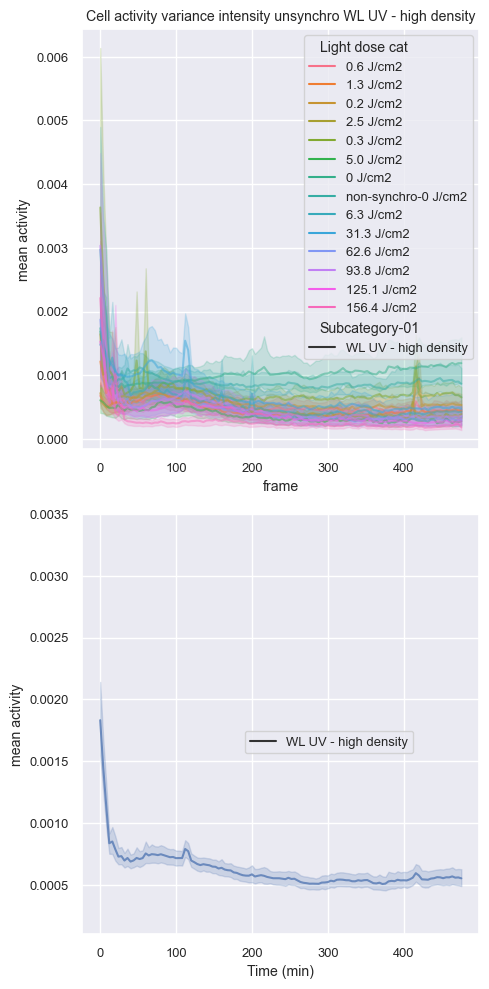

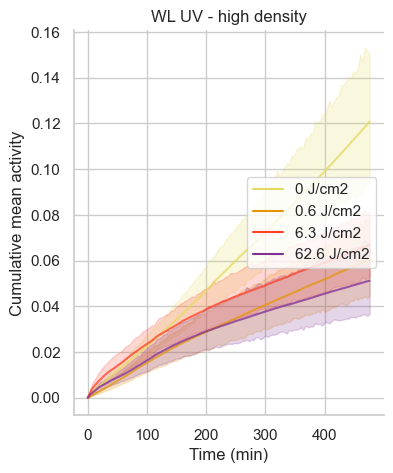

In [12]:
# hue_order = ['control-00ms', '25ms', '50ms', '100ms', '200ms', '400ms', '800ms',
#              '01sec', '05sec', '10sec', '15sec', '20sec', '25sec'] 

data_path = os.path.join(output_path, folder, "data_activity_{0}.csv".format(method))

activity_metrics = pd.read_csv(data_path)

hue_order = ['0 J/cm2','0.6 J/cm2', '6.3 J/cm2', '62.6 J/cm2']

# Estimate the ligth dose
light_power = 6.255662 # fixed power value according to our microscope
activity_metrics = photofitt.utils.numerical_dose(activity_metrics, column_name="Subcategory-02", power=light_power)
if folder=="unsynchro":
    activity_metrics = photofitt.utils.power_conversion(activity_metrics, dose_column="Light dose", condition_col="Subcategory-02", condition_name='control-00ms')
else:
    activity_metrics = photofitt.utils.power_conversion(activity_metrics, dose_column="Light dose", condition_col="Subcategory-02", condition_name='Control-sync')

wavelength = np.unique(activity_metrics["Subcategory-01"])

y = "mean activity"
hue="Light dose cat"
for w in wavelength:
    activity_w = activity_metrics[activity_metrics["Subcategory-01"]==w].reset_index(drop=True)
    activity_w.to_csv(os.path.join(output_path, "data_activity_{0}_{1}.csv".format(method, w)))
    
    wpath = os.path.join(output_path, "plots", w)
    os.makedirs(wpath, exist_ok=True)
    # Plot temporal distribution of the activity
    conditions_with_aggregates(activity_w, y,
                               "Cell activity variance {0} {1} {2}".format(method, condition, w),
                               wpath,
                               "activity_variance_{0}_{1}_{2}.png".format(method, condition, w),
                               hue=hue, style="Subcategory-01", ylim = [0.0001, 0.0035])
    
    ## Plot additive activity
    activity_w_dataframe, activity_w = cumulative_activity(activity_w, y, use_starting_point="None", starting_point=0)
    
    y_var = f"Cumulative {y}"
    format_extension = 'pdf'
    name = "cell_cumulative_activity_{0}.{1}".format(w, format_extension)
    title = f"{w}"
    
    display.conditions(activity_w, y_var, 
               title, 
               hue, 
               wpath, name, 
               hue_order=hue_order,
               palette=sns.color_palette("CMRmap_r", 5), #17
               figsize=(4, 5), style=None)